# RAG Evaluation
- Original nb from https://huggingface.co/learn/cookbook/en/rag_evaluation#evaluating-rag-performance.   Going fully open source, local, optimized for speed with exl2

- RAG systems are complex: here a RAG diagram, where we noted in blue all possibilities for system enhancement:

<img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/RAG_workflow.png" height="700">

In [1]:
from tqdm.auto import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import json
import datasets

pd.set_option("display.max_colwidth", None)

In [2]:
from huggingface_hub import notebook_login

notebook_login()

### Load your knowledge base

# 1. Build a synthetic dataset for evaluation

### 1.1. Prepare source documents

- Drop REFERENCES onward, respecting previous discoveries that these just introduce noise to retrieval.  Must process new docs the same way!

In [4]:
os.getcwd()

'/home/mainuser/Desktop/LLMs/RagOverArXiv/nbs'

In [5]:
import os
import PyPDF2
from PyPDF2 import PdfReader
from pathlib import Path
PDFS_PATH = Path('../data/pdfs_ws_mrkp_test/pdfs')
PDFS = list(PDFS_PATH.glob('*.pdf'))
PDFS[0], len(PDFS)

reader = PdfReader(os.path.expanduser(PDFS[0]))
pages = reader.pages
documents = []
for page in pages:
  documents.append(page.extract_text())


def load_pdf_to_string(pdf_path):
    # Open the PDF file in binary mode
    with open(pdf_path, 'rb') as file:
        # Create a PDF file reader object
        pdf_reader = PyPDF2.PdfReader(file)

        # Initialize an empty string to hold the text
        text = ''

        # Loop through each page and extract the text
        for page_num in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_num]
            page_text = page.extract_text()
            references_index= page_text.upper().find('\nREFERENCES\n')
            if references_index != -1:
              page_text = page_text[:references_index]
              text += page_text
              return text
            text += page_text
    return text

# Use the function to load a PDF into a string
text = load_pdf_to_string(os.path.expanduser(PDFS[0]))
def get_title(pdf_path): return os.path.expanduser(pdf_path).split('/')[-1]

all_docs_and_titles = [(load_pdf_to_string(os.path.expanduser(pdf_path)),get_title(pdf_path)) for pdf_path in PDFS]

all_docs = [doc[0] for doc in all_docs_and_titles]
all_titles = [doc[1] for doc in all_docs_and_titles]

from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter, TokenTextSplitter, RecursiveCharacterTextSplitter
from langchain.docstore.document import Document 

# CHUNK_SIZE = 1000 #try 2000 next
# CHUNK_OVERLAP = 30 #try 200 next
CHUNK_SIZE = 2000 #try 2000 next
CHUNK_OVERLAP = 200 #try 200 next

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap = CHUNK_OVERLAP,
    length_function=len,
)

docs_processed  = [text_splitter.split_documents([Document(page_content=doc, metadata={'source':all_titles[idx]})]) 
         for idx,doc in enumerate(all_docs)]



In [6]:
docs_processed = [txt for doc in docs_processed for txt in doc]

In [7]:
len(docs_processed)

262

In [8]:
docs_processed[0]

Document(page_content='TinyLlama: An Open-Source Small Language Model\nPeiyuan Zhang∗Guangtao Zeng∗Tianduo Wang Wei Lu\nStatNLP Research Group\nSingapore University of Technology and Design\n{peiyuan_zhang, tianduo_wang, luwei}@sutd.edu.sg\nguangtao_zeng@mymail.sutd.edu.sg\nAbstract\nWe present TinyLlama, a compact 1.1B language model pretrained on around 1\ntrillion tokens for approximately 3 epochs. Building on the architecture and tok-\nenizer of Llama 2 (Touvron et al., 2023b), TinyLlama leverages various advances\ncontributed by the open-source community (e.g., FlashAttention (Dao, 2023)),\nachieving better computational efficiency. Despite its relatively small size, TinyL-\nlama demonstrates remarkable performance in a series of downstream tasks. It\nsignificantly outperforms existing open-source language models with compara-\nble sizes. Our model checkpoints and code are publicly available on GitHub at\nhttps://github.com/jzhang38/TinyLlama .\n1 Introduction\nRecent progress in 

- Make embeddings and save to vector store
- Currently taking from Part3_Metadata+ArXivExplore_single_source nb, should tune

In [26]:
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore

store = LocalFileStore("./cache/")

#embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'
embed_model_id = 'mixedbread-ai/mxbai-embed-large-v1'

core_embeddings_model = HuggingFaceEmbeddings(
    model_name=embed_model_id
)

embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings_model, store, namespace=embed_model_id
)


from langchain.schema.document import Document

for index, pdf in enumerate(docs_processed):
   content = docs_processed[index]
   if index == 0:
       vector_store = FAISS.from_documents([content], embedder)
   else:
      vector_store_i = FAISS.from_documents([content], embedder)
      vector_store.merge_from(vector_store_i)

vector_store


#### TODO: Once have the pipeline working and have a baseline, look into https://huggingface.co/spaces/mteb/leaderboard.  SFR-Embedding-Mistral or something along those lines may work much better.

In [27]:
vector_store.save_local('../data/rag_index_dir')

### 1.2. Setup agents for question generation

- HF used [Mixtral](https://huggingface.co/mistralai/Mixtral-8x7B-Instruct-v0.1) for QA couple generation because it it has excellent performance in leaderboards such as [Chatbot Arena](https://huggingface.co/spaces/lmsys/chatbot-arena-leaderboard).  Used Mixtral-8x7b-4bit exl2, and it did not appear significantly better than Mistral, so using Mistral for speed but may come back to this.

#### TODO: Tried Mixtral4Bit, visually perhaps a bit better, but overfits on 'deep question'. Perhaps return to this after looking at embedding model

In [11]:
from exllamav2 import *
from exllamav2.generator import *
import sys, torch


generator_config = ExLlamaV2Config()
generator_config.model_dir = "/home/mainuser/Desktop/LLMs/MiStralInference"
#generator_config.model_dir = '/home/mainuser/Desktop/LLMs/Mixtral4bit'
generator_config.prepare()

generator_model = ExLlamaV2(generator_config)
cache = ExLlamaV2Cache(generator_model, lazy = True)

print("Loading model...")
generator_model.load_autosplit(cache)

generator_tokenizer = ExLlamaV2Tokenizer(generator_config)
generator_llm = ExLlamaV2StreamingGenerator(generator_model, cache, generator_tokenizer)
generator_llm.set_stop_conditions([generator_tokenizer.eos_token_id])
generator_settings = ExLlamaV2Sampler.Settings()
generator_settings.temperature = 0.85
generator_settings.top_k = 50
generator_settings.top_p = 0.8
generator_settings.token_repetition_penalty = 1.01
#generator_settings.disallow_tokens(generator_tokenizer, [generator_tokenizer.eos_token_id])
# see if commenting out the above solved the endless generation issue (did not have with stream generator)

Loading model...


In [15]:
#Working except eos
from transformers import Pipeline
from ragatouille import RAGPretrainedModel
from typing import Optional, List, Tuple
from langchain.docstore.document import Document
import time

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
from langchain.docstore.document import Document as LangchainDocument
def call_llm(
    question: str,
    generator: ExLlamaV2StreamingGenerator,
    tokenizer: ExLlamaV2Tokenizer,
    settings:ExLlamaV2Sampler.Settings,
    max_new_tokens = 512
) -> Tuple[str, List[LangchainDocument]]:

    max_new_tokens = max_new_tokens

    generator.warmup()
    output = generator.generate_simple(f"<s>[INST] {question} [/INST]", settings, max_new_tokens, seed = 1234)
    return output


call_llm(question="How can I get my cat to like me?", generator=generator_llm,tokenizer=generator_tokenizer,settings=generator_settings,max_new_tokens=1024)

'<s>[INST] How can I get my cat to like me? [/INST] 1. Spend time with your cat: Cats enjoy spending time with their owners, so take some time out of your day to play with them or simply sit with them.\n\n2. Provide food and shelter: Ensure that your cat has access to good food and a comfortable place to sleep.\n\n3. Show affection: Cats love affection, so try petting them or giving them a gentle scratch behind their ears.\n\n4. Play with toys: Cats enjoy playing with toys, so try playing with them using a laser pointer or a feather wand.\n\n5. Be patient: Cats can be stubborn and may take some time to warm up to their owners. Be patient and continue to show them love and affection.\n\n6. Avoid loud noises: Cats are sensitive to loud noises, so try to avoid making loud noises in their presence.\n\n7. Provide mental stimulation: Cats enjoy mental stimulation, so try hiding treats or toys around the house for them to find.\n\n8. Give them attention: Cats enjoy attention, so try giving th

In [16]:
QA_generation_prompt = """
Your task is to write a deep factual or conceptual question and an answer given a context.
Your deep question should be unambigiously answerable from the context.
Your deep question should be formulated in the same style as questions people reading advanced LLM papers would ask.
This means that your question MUST NOT mention something like "according to the passage" or "context".

Provide your answer as follows:

Output:::
Deep question: (your deep question)
Answer: (your answer to the deep question)

Now here is the context.

Context: {context}\n
Output:::"""

Now let's generate our QA couples.
For this example, we generate only 10 QA couples and will load the rest from the Hub.

But for your specific knowledge base, given that you want to get at least ~100 test samples, and accounting for the fact that we will filter out around half of these with our critique agents later on, you should generate much more, in the >200 samples.

In [28]:
import random
from tqdm import tqdm
N_GENERATIONS = 200  # We intentionally generate only 10 QA couples here for cost and time considerations

print(f"Generating {N_GENERATIONS} QA couples...")

outputs = []
for sampled_context in tqdm(random.sample(docs_processed, N_GENERATIONS)):
    # Generate QA couple
    # output_QA_couple = call_llm(
    #     llm_client, QA_generation_prompt.format(context=sampled_context.page_content)
    # )
    output_QA_couple = call_llm(question=QA_generation_prompt.format(context=sampled_context.page_content), generator=generator_llm,tokenizer=generator_tokenizer,settings=generator_settings,
                                max_new_tokens=1024)
    try:
        question = output_QA_couple.split("Deep question: ")[-1].split("Answer: ")[0]
        answer = output_QA_couple.split("Answer: ")[-1]
        #assert len(answer) < 300, "Answer is too long"
        outputs.append(
            {
                "context": sampled_context.page_content,
                "question": question,
                "answer": answer,
                "source_doc": sampled_context.metadata["source"],
            }
        )
    except:
        continue

Generating 200 QA couples...


100%|██████████| 200/200 [04:58<00:00,  1.49s/it]


In [29]:
outputs[:2]

[{'context': 'is illustrated in Figure 2, it should be noted that it varies\nacross individuals (Tversky & Kahneman, 1992). There\nare also other functional forms for the value function that\nhave been proposed in later work (Gurevich et al., 2009).\nThe salient qualities of a value function are: the existence\nof a reference point that is added or subtracted to get the\nrelative gain or loss respectively; concavity in relative gains\n(i.e. diminishing sensitivity away from zref); loss aversion\n(i.e., greater sensitivity to losses).\n3.2. HALOs\nInformally, HALOs are loss functions that model the human\nbiases in Tversky & Kahneman (1992). Formally,\nDefinition 3.4 (HALOs ).Letx∈ X denote an input and\ny∈ Y an output. Then f: (x, y)→ Ris ahuman-aware\nloss function if there exists the following: a parameterized\nreward function rθsuch that ∀(x1, y1),(x2, y2)∈ X × Y ,\nrθ(x1, y1)> rθ(x2, y2)⇐⇒ (x1, y1)≻rθ(x2, y2)\nreference point distributions Qx(X′), Qy(Y′|X′), a value\nfunction vf: R

In [30]:
import pandas as pd
pd.set_option('display.max_colwidth',800)
display(pd.DataFrame(outputs).head(2))

,context,question,answer,source_doc
0,"is illustrated in Figure 2, it should be noted that it varies\nacross individuals (Tversky & Kahneman, 1992). There\nare also other functional forms for the value function that\nhave been proposed in later work (Gurevich et al., 2009).\nThe salient qualities of a value function are: the existence\nof a reference point that is added or subtracted to get the\nrelative gain or loss respectively; concavity in relative gains\n(i.e. diminishing sensitivity away from zref); loss aversion\n(i.e., greater sensitivity to losses).\n3.2. HALOs\nInformally, HALOs are loss functions that model the human\nbiases in Tversky & Kahneman (1992). Formally,\nDefinition 3.4 (HALOs ).Letx∈ X denote an input and\ny∈ Y an output. Then f: (x, y)→ Ris ahuman-aware\nloss function if there exists the following: a ...","Given that HALOs are loss functions that model human biases in Tversky & Kahneman (1992), what is the definition of a human-aware loss function according to Definition 3.4 in this context?\n\n","A human-aware loss function is a function f: (x, y) → Ris that assigns higher rewards to input-output pairs that are more preferred under it, and satisfies the following conditions: there exists a parameterized reward function rθ such that rθ(x1, y1) > rθ(x2, y2) ⇐⇒ (x1, y1) ≻ rθ(x2, y2) where x′ ∼ Qx(X′) and y′ ∼ Qy(Y′|x′), and a value function vf: R → R that is monotonic non-decreasing and concave in (0,∞), and a negative affine function ts such that f(x, y;θ) = t(vf(rθ(x, y) − Ex′, y′[rθ(x′, y′)])) where Ex′ is the expected reward with respect to input-output pairs sampled from the distributions Qx and Qy.",2402.01306v1.pdf
1,"tional cost—especially in the context of LLM pre-training.\nTo be more specific, an extensive comparative study neces-\nsarily entails pre-training (i) various sizes of LLMs, (ii) for\na variety of data sampling rates, (iii) obtained through vari-\nous pruning strategies. Further, downstream evaluations for\nLLMs also frequently involve fine-tuning, which is resource\nintensive in itself.\n1.1. Contributions\nWe hypothesize that the roles of coverage and quality de-\npend on the stage of training, size of the model, and the\nsampling rate. To understand the coverage/quality design\nchoice better, we develop new data-efficiency routines that\nindependently (and solely) target quality and coverage. Our\nASK-LLM sampler prioritizes high-quality and informative\ntraining samples by asking ...","In the context of LLM pre-training, how does the size of the model affect the roles of coverage and quality?\n\n","We hypothesize that the roles of coverage and quality depend on the stage of training, size of the model, and the sampling rate. Specifically, we find that ASK-LLM sampling can train better models even after removing up to 90% of training samples, while also consistently beating well-established data curation routines. The size of the model also affects the sampling cost, which in turn impacts the quality and coverage of the pre-trained model. Our analysis shows that ASK-LLM sampling can outperform most baselines with a tiny proxy model of only 60M parameters.",2402.09668v1.pdf


### 1.3. Setup critique agents

The questions generated by the previous agent can have many flaws: we should do a quality check before validating these questions.

We thus build critique agents that will rate each question on several criteria, given in [this paper](https://huggingface.co/papers/2312.10003):
- **Groundedness:** can the question be answered from the given context?
- **Relevance:** is the question relevant to users? For instance, `"What is the date when transformers 4.29.1 was released?"` is not relevant for ML practicioners.

One last failure case we've noticed is when a function is tailored for the particular setting where the question was generated, but undecipherable by itself, like `"What is the name of the function used in this guide?"`.
We also build a critique agent for this criteria:
- **Stand-alone**: is the question understandable free of any context, for someone with domain knowledge/Internet access? The opposite of this would be `What is the function used in this article?` for a question generated from a specific blog article.

We systematically score functions with all these agents, and whenever the score is too low for any one of the agents, we eliminate the question from our eval dataset.

💡 ___When asking the agents to output a score, we first ask them to produce its rationale. This will help us verify scores, but most importantly, asking it to first output rationale gives the model more tokens to think and elaborate an answer before summarizing it into a single score token.___

We now build and run these critique agents.

In [31]:

# ## Semi-working backup
# question_groundedness_critique_prompt = """
# You will be given a context and a question.
# Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
# Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

# Provide your answer as follows:

# Answer:::
# Evaluation: (your rationale for the rating, as a text)
# Total rating: !!!(your rating, as a number between 1 and 5)!!!

# You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.  'Total rating:' should be encolsed in !!! and !!! as in '!!!4.5!!!'.


# Now here are the question and context.

# Question: {question}\n
# Context: {context}\n
# Answer::: """

# question_relevance_critique_prompt = """
# You will be given a question.
# Your task is to provide a 'total rating' representing how useful this question can be to machine learning developers building NLP applications with the Hugging Face ecosystem.
# Give your answer on a scale of 1 to 5, where 1 means that the question is not useful at all, and 5 means that the question is extremely useful.

# Provide your answer as follows:

# Answer:::
# Evaluation: (your rationale for the rating, as a text)
# Total rating: !!!(your rating, as a number between 1 and 5)!!!

# You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.  'Total rating:' should be encolsed in !!! and !!! as in '!!!4.5!!!'.


# Now here is the question.

# Question: {question}\n
# Answer::: """

# question_standalone_critique_prompt = """
# You will be given a question.
# Your task is to provide a 'total rating' representing how context-independent this question is.
# Give your answer on a scale of 1 to 5, where 1 means that the question depends on additional information to be understood, and 5 means that the question makes sense by itself.
# For instance, if the question refers to a particular setting, like 'in the context' or 'in the document', the rating must be 1.
# The questions can contain obscure technical nouns or acronyms like Gradio, Hub, Hugging Face or Space and still be a 5: it must simply be clear to an operator with access to documentation what the question is about.

# For instance, "What is the name of the checkpoint from which the ViT model is imported?" should receive a 1, since there is an implicit mention of a context, thus the question is not independent from the context.

# Provide your answer as follows:

# Answer:::
# Evaluation: (your rationale for the rating, as a text)
# Total rating: !!!(your rating, as a number between 1 and 5)!!!

# You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.  'Total rating:' should be encolsed in !!! and !!! as in '!!!4.5!!!'.


# Now here is the question.

# Question: {question}\n
# Answer::: """

In [32]:
question_groundedness_critique_prompt = """
You will be given a context and a question.
Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here are the question and context.

Question: {question}\n
Context: {context}\n
Answer::: """

question_relevance_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how useful this question can be to machine learning developers building NLP applications with the Hugging Face ecosystem.
Give your answer on a scale of 1 to 5, where 1 means that the question is not useful at all, and 5 means that the question is extremely useful.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: {question}\n
Answer::: """

question_standalone_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how context-independant this question is.
Give your answer on a scale of 1 to 5, where 1 means that the question depends on additional information to be understood, and 5 means that the question makes sense by itself.
For instance, if the question refers to a particular setting, like 'in the context' or 'in the document', the rating must be 1.
The questions can contain obscure technical nouns or acronyms like Gradio, Hub, Hugging Face or Space and still be a 5: it must simply be clear to an operator with access to documentation what the question is about.

For instance, "What is the name of the checkpoint from which the ViT model is imported?" should receive a 1, since there is an implicit mention of a context, thus the question is not independant from the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: {question}\n
Answer::: """

In [33]:
print("Generating critique for each QA couple...")
for output in tqdm(outputs):
    evaluations = {
        "groundedness": call_llm(question=question_groundedness_critique_prompt.format(context=output["context"], question=output["question"]), 
                                generator=generator_llm,
                                tokenizer=generator_tokenizer,settings=generator_settings,
                                max_new_tokens=1024),
        "relevance": call_llm(question=question_relevance_critique_prompt.format(question=output["question"]), 
                                generator=generator_llm,
                                tokenizer=generator_tokenizer,settings=generator_settings,
                                max_new_tokens=1024),
                    
        "standalone": call_llm(question=question_standalone_critique_prompt.format(question=output["question"]),
                                generator=generator_llm,
                                tokenizer=generator_tokenizer,settings=generator_settings,
                                max_new_tokens=1024)
    }
    try:
        for criterion, evaluation in evaluations.items():
            score, eval = (
                # int(evaluation.split("Total rating: ")[-1].strip()),
                (evaluation.split("Total rating: ")[-1].strip()),
                evaluation.split("Total rating: ")[-2].split("Evaluation: ")[1],
            )
            output.update(
                {
                    f"{criterion}_score": score,
                    f"{criterion}_eval": eval,
                }
            )
    except Exception as e:
        #print("\033[91m" + f"EVALUATION:" + "\033[0m")
        #print(evaluations)
        #print("\033[91m" + f"EXCEPTION: {e}" + "\033[0m")
        continue

Generating critique for each QA couple...


100%|██████████| 200/200 [12:37<00:00,  3.79s/it]


In [34]:
evaluations

{'groundedness': '<s>[INST] \nYou will be given a context and a question.\nYour task is to provide a \'total rating\' scoring how well one can answer the given question unambiguously with the given context.\nGive your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.\n\nProvide your answer as follows:\n\nAnswer:::\nEvaluation: (your rationale for the rating, as a text)\nTotal rating: (your rating, as a number between 1 and 5)\n\nYou MUST provide values for \'Evaluation:\' and \'Total rating:\' in your answer.\n\nNow here are the question and context.\n\nQuestion: Can the associative "System 1" of LMs be beneficially augmented by a "System 2" based on searching a tree of possible paths to the solution to a problem?\n\n\n\nContext: Conclusion. The associative “System 1” of LMs can be beneficially augmented by a “System 2”\nbased on searching a tre

Now let us filter out bad questions based on our critique agent scores:

In [35]:
outputs[0].keys()

dict_keys(['context', 'question', 'answer', 'source_doc', 'groundedness_score', 'groundedness_eval', 'relevance_score', 'relevance_eval', 'standalone_score', 'standalone_eval'])

In [36]:
import pandas as pd

pd.set_option("display.max_colwidth", None)

generated_questions = pd.DataFrame.from_dict(outputs)

print("Evaluation dataset before filtering:")
display(
    generated_questions[
        [
            "question",
            "answer",
            "groundedness_score",
            "relevance_score",
            "standalone_score",
        ]
    ]
)

Evaluation dataset before filtering:


,question,answer,groundedness_score,relevance_score,standalone_score
0,"Given that HALOs are loss functions that model human biases in Tversky & Kahneman (1992), what is the definition of a human-aware loss function according to Definition 3.4 in this context?\n\n","A human-aware loss function is a function f: (x, y) → Ris that assigns higher rewards to input-output pairs that are more preferred under it, and satisfies the following conditions: there exists a parameterized reward function rθ such that rθ(x1, y1) > rθ(x2, y2) ⇐⇒ (x1, y1) ≻ rθ(x2, y2) where x′ ∼ Qx(X′) and y′ ∼ Qy(Y′|x′), and a value function vf: R → R that is monotonic non-decreasing and concave in (0,∞), and a negative affine function ts such that f(x, y;θ) = t(vf(rθ(x, y) − Ex′, y′[rθ(x′, y′)])) where Ex′ is the expected reward with respect to input-output pairs sampled from the distributions Qx and Qy.",5,4,4
1,"In the context of LLM pre-training, how does the size of the model affect the roles of coverage and quality?\n\n","We hypothesize that the roles of coverage and quality depend on the stage of training, size of the model, and the sampling rate. Specifically, we find that ASK-LLM sampling can train better models even after removing up to 90% of training samples, while also consistently beating well-established data curation routines. The size of the model also affects the sampling cost, which in turn impacts the quality and coverage of the pre-trained model. Our analysis shows that ASK-LLM sampling can outperform most baselines with a tiny proxy model of only 60M parameters.",4.5\n\nThe study provides a clear and unambiguous answer to the question about the roles of coverage and quality in LLM pre-training. The authors provide a comprehensive analysis of the factors that affect these roles and present new data-efficiency routines to address the trade-off between coverage and quality. The study also includes extensive benchmarks and new insights to support the conclusions. The only reason for not giving a perfect rating is that the study does not provide a direct comparison between coverage and quality in terms of their impact on downstream performance.,"4\n\nOverall, this question is moderately useful for machine learning developers building NLP applications with the Hugging Face ecosystem, as it provides insight into the factors that influence the performance of LLM pre-trained models. However, it may not be as useful for developers who are already familiar with these concepts or who are focused on specific aspects of NLP model development.",NaN
2,"Given the context, what is the architecture of TinyLlama?\n\n","TinyLlama uses a Transformer architecture based on Vaswani et al. (2017) with the following details: Hidden size of 2,048, intermediate hidden size of 5,632, context length of 2,048, 16 heads, 32 layers, and a vocabulary size of 32,000. It also uses RoPE (Rotary Positional Embedding) for positional information, RMSNorm for normalization, SwiGLU as the activation function, and grouped-query attention to reduce memory bandwidth overhead and speed up inference.",5,NaN,NaN
3,"In this context, what is the difference between the first and second categories of baselines with retrievals?\n\n","The first category of baselines with retrievals includes standard RAG baselines where an LM generates output given the query prepended with the top retrieved documents using the same retriever as in the system. It also includes Llama2-FT, where Llama2 is fine-tuned on all training data without the reflection tokens or retrieved passages. The second category includes concurrent methods that are trained with retrieved text passages, such as SAIL and Toolformer.",5,"4.\n\nThe question is useful because it provides a clear and specific focus on the difference between two categories of baselines in a particular context. However, it might be more useful if it were to provide more details about the context and the specific task in question. Nonetheless, it is still a va

In [37]:
generated_questions['groundedness_score']=generated_questions['groundedness_score'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)
generated_questions['relevance_score']=generated_questions['relevance_score'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)
generated_questions['standalone_score']=generated_questions['groundedness_score'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)

In [39]:
generated_questions.head(2)

,context,question,answer,source_doc,groundedness_score,groundedness_eval,relevance_score,relevance_eval,standalone_score,standalone_eval
0,"is illustrated in Figure 2, it should be noted that it varies\nacross individuals (Tversky & Kahneman, 1992). There\nare also other functional forms for the value function that\nhave been proposed in later work (Gurevich et al., 2009).\nThe salient qualities of a value function are: the existence\nof a reference point that is added or subtracted to get the\nrelative gain or loss respectively; concavity in relative gains\n(i.e. diminishing sensitivity away from zref); loss aversion\n(i.e., greater sensitivity to losses).\n3.2. HALOs\nInformally, HALOs are loss functions that model the human\nbiases in Tversky & Kahneman (1992). Formally,\nDefinition 3.4 (HALOs ).Letx∈ X denote an input and\ny∈ Y an output. Then f: (x, y)→ Ris ahuman-aware\nloss function if there exists the following: a parameterized\nreward function rθsuch that ∀(x1, y1),(x2, y2)∈ X × Y ,\nrθ(x1, y1)> rθ(x2, y2)⇐⇒ (x1, y1)≻rθ(x2, y2)\nreference point distributions Qx(X′), Qy(Y′|X′), a value\nfunction vf: R→ Rthat is monotonic non-decreasing and\nconcave in (0,∞), and a negative affine function tsuch that\nf(x, y;θ) =t(vf(rθ(x, y)−Ex′,y′[rθ(x′, y′)])) (5)\nwhere x′∼Qx(X′)andy′∼Qy(Y′|x′).\nPut simply, the requirement for the reward function is that it\nassigns higher rewards to input-output pairs that are more\n3Model Alignment as Prospect Theoretic Optimization\npreferred under it. The reference point is the expected re-\nward with respect to input-output pairs sampled from the\ndistributions Qx, Qy. We require that the value function\nbe concave in gains but not necessarily convex in losses—\nunlike the canonical Kahneman-Tversky value functions—\nbecause in the original work on prospect theory, a minority\nof individuals were found to be risk-averse in both the gain\nand loss regime (i.e., concave in both gains and losses)\n(Kahneman & Tversky, 1979). Note that risk-aversion is\ndifferent from loss-aversion; they relate to the curvature and\nmagnitude of the slope respectively.\nProposition 3.5. DPO, SLiC (calibration loss only), and","Given that HALOs are loss functions that model human biases in Tversky & Kahneman (1992), what is the definition of a human-aware loss function according to Definition 3.4 in this context?\n\n","A human-aware loss function is a function f: (x, y) → Ris that assigns higher rewards to input-output pairs that are more preferred under it, and satisfies the following conditions: there exists a parameterized reward function rθ such that rθ(x1, y1) > rθ(x2, y2) ⇐⇒ (x1, y1) ≻ rθ(x2, y2) where x′ ∼ Qx(X′) and y′ ∼ Qy(Y′|x′), and a value function vf: R → R that is monotonic non-decreasing and concave in (0,∞), and a negative affine function ts such that f(x, y;θ) = t(vf(rθ(x, y) − Ex′, y′[rθ(x′, y′)])) where Ex′ is the expected reward with respect to input-output pairs sampled from the distributions Qx and Qy.",2402.01306v1.pdf,5.0,"Given the context, the question is clearly and unambiguously answerable with the provided context. The definition of a human-aware loss function according to Definition 3.4 in Tversky & Kahneman (1992) is provided in the text and can be easily understood with the provided information.\n\n",4.0,"This question is useful for machine learning developers building NLP applications with the Hugging Face ecosystem because it requires an understanding of HALOs and their role in modeling human biases in Tversky & Kahneman (1992). The question also asks for a specific definition of a human-aware loss function according to Definition 3.4 in this context, which can help developers to better understand how to incorporate human awareness into their loss functions.\n\n",5.0,This question is context-dependent because it references a specific paper and a specific definition.\n\n
1,"tional cost—especially in the context of LLM pre-training.\nTo be more specific, an extensive comparative stud

In [41]:
os.getcwd()

'/home/mainuser/Desktop/LLMs/RagOverArXiv/nbs'

In [42]:
generated_questions.to_csv("../data/pdfs_ws_mrkp_test/generated_questions_pdf_raw.csv", index=False)

In [43]:
display(
    generated_questions[
        [
            "question",
            "answer",
            "groundedness_score",
            "relevance_score",
            "standalone_score",
        ]
    ]
)

,question,answer,groundedness_score,relevance_score,standalone_score
0,"Given that HALOs are loss functions that model human biases in Tversky & Kahneman (1992), what is the definition of a human-aware loss function according to Definition 3.4 in this context?\n\n","A human-aware loss function is a function f: (x, y) → Ris that assigns higher rewards to input-output pairs that are more preferred under it, and satisfies the following conditions: there exists a parameterized reward function rθ such that rθ(x1, y1) > rθ(x2, y2) ⇐⇒ (x1, y1) ≻ rθ(x2, y2) where x′ ∼ Qx(X′) and y′ ∼ Qy(Y′|x′), and a value function vf: R → R that is monotonic non-decreasing and concave in (0,∞), and a negative affine function ts such that f(x, y;θ) = t(vf(rθ(x, y) − Ex′, y′[rθ(x′, y′)])) where Ex′ is the expected reward with respect to input-output pairs sampled from the distributions Qx and Qy.",5.0,4.0,5.0
1,"In the context of LLM pre-training, how does the size of the model affect the roles of coverage and quality?\n\n","We hypothesize that the roles of coverage and quality depend on the stage of training, size of the model, and the sampling rate. Specifically, we find that ASK-LLM sampling can train better models even after removing up to 90% of training samples, while also consistently beating well-established data curation routines. The size of the model also affects the sampling cost, which in turn impacts the quality and coverage of the pre-trained model. Our analysis shows that ASK-LLM sampling can outperform most baselines with a tiny proxy model of only 60M parameters.",4.5,4.0,4.5
2,"Given the context, what is the architecture of TinyLlama?\n\n","TinyLlama uses a Transformer architecture based on Vaswani et al. (2017) with the following details: Hidden size of 2,048, intermediate hidden size of 5,632, context length of 2,048, 16 heads, 32 layers, and a vocabulary size of 32,000. It also uses RoPE (Rotary Positional Embedding) for positional information, RMSNorm for normalization, SwiGLU as the activation function, and grouped-query attention to reduce memory bandwidth overhead and speed up inference.",5.0,NaN,5.0
3,"In this context, what is the difference between the first and second categories of baselines with retrievals?\n\n","The first category of baselines with retrievals includes standard RAG baselines where an LM generates output given the query prepended with the top retrieved documents using the same retriever as in the system. It also includes Llama2-FT, where Llama2 is fine-tuned on all training data without the reflection tokens or retrieved passages. The second category includes concurrent methods that are trained with retrieved text passages, such as SAIL and Toolformer.",5.0,4.0,5.0
4,How effective are prompting strategies for in-context learning in encoder-decoder language models?\n\n,"Encoder-decoder language models with prompting strategies have shown to be effective for in-context learning tasks such as open-domain question answering. The two prompting strategies identified for in-context learning, strategy 1 and strategy 2, have demonstrated improvements in performance compared to decoder-only LMs. The use of in-context examples and relevant passage retrieval with the target question has also been shown to be beneficial for in-context learning.",4.5,4.0,4.5
...,...,...,...,...,...
195,"In adherence to Llama 2, what optimizer and learning rate schedule were used during the pretraining phase of TinyLlama?\n\n","The optimizer used during the pretraining phase of TinyLlama was AdamW, with β1 set at 0.9 and β2 set at 0.95. A cosine learning rate schedule was also employed, with a maximum learning rate of 4.0×10−4 and a minimum learning rate of 4.0×10−5. Additionally, 2,000 warmup steps were used to facilitate optimized learning.",5.0,4.0,5.0
196,Can refining old thoughts be considered a third approach to thought generation in the ToT framework?\n\n,"Yes, refining old thoughts can be considered a third approach to thought gen

In [44]:
for col in ["groundedness_score", "relevance_score", "standalone_score"]:
    generated_questions[col] = generated_questions[col].fillna(generated_questions[["groundedness_score", "relevance_score", "standalone_score"]].min(axis=1))

In [45]:

generated_questions = generated_questions.loc[
    (generated_questions["groundedness_score"] >= 3.0)
    & (generated_questions["relevance_score"] >= 3.0)
    & (generated_questions["standalone_score"] >= 3.0)
]
print("============================================")
print("Final evaluation dataset:")
display(
    generated_questions[
        [
            "question",
            "answer",
            "groundedness_score",
            "relevance_score",
            "standalone_score",
        ]
    ]
)

# eval_dataset = datasets.Dataset.from_pandas(
#     generated_questions, split="train", preserve_index=False
# )

Final evaluation dataset:


,question,answer,groundedness_score,relevance_score,standalone_score
0,"Given that HALOs are loss functions that model human biases in Tversky & Kahneman (1992), what is the definition of a human-aware loss function according to Definition 3.4 in this context?\n\n","A human-aware loss function is a function f: (x, y) → Ris that assigns higher rewards to input-output pairs that are more preferred under it, and satisfies the following conditions: there exists a parameterized reward function rθ such that rθ(x1, y1) > rθ(x2, y2) ⇐⇒ (x1, y1) ≻ rθ(x2, y2) where x′ ∼ Qx(X′) and y′ ∼ Qy(Y′|x′), and a value function vf: R → R that is monotonic non-decreasing and concave in (0,∞), and a negative affine function ts such that f(x, y;θ) = t(vf(rθ(x, y) − Ex′, y′[rθ(x′, y′)])) where Ex′ is the expected reward with respect to input-output pairs sampled from the distributions Qx and Qy.",5.0,4.0,5.0
1,"In the context of LLM pre-training, how does the size of the model affect the roles of coverage and quality?\n\n","We hypothesize that the roles of coverage and quality depend on the stage of training, size of the model, and the sampling rate. Specifically, we find that ASK-LLM sampling can train better models even after removing up to 90% of training samples, while also consistently beating well-established data curation routines. The size of the model also affects the sampling cost, which in turn impacts the quality and coverage of the pre-trained model. Our analysis shows that ASK-LLM sampling can outperform most baselines with a tiny proxy model of only 60M parameters.",4.5,4.0,4.5
2,"Given the context, what is the architecture of TinyLlama?\n\n","TinyLlama uses a Transformer architecture based on Vaswani et al. (2017) with the following details: Hidden size of 2,048, intermediate hidden size of 5,632, context length of 2,048, 16 heads, 32 layers, and a vocabulary size of 32,000. It also uses RoPE (Rotary Positional Embedding) for positional information, RMSNorm for normalization, SwiGLU as the activation function, and grouped-query attention to reduce memory bandwidth overhead and speed up inference.",5.0,5.0,5.0
3,"In this context, what is the difference between the first and second categories of baselines with retrievals?\n\n","The first category of baselines with retrievals includes standard RAG baselines where an LM generates output given the query prepended with the top retrieved documents using the same retriever as in the system. It also includes Llama2-FT, where Llama2 is fine-tuned on all training data without the reflection tokens or retrieved passages. The second category includes concurrent methods that are trained with retrieved text passages, such as SAIL and Toolformer.",5.0,4.0,5.0
4,How effective are prompting strategies for in-context learning in encoder-decoder language models?\n\n,"Encoder-decoder language models with prompting strategies have shown to be effective for in-context learning tasks such as open-domain question answering. The two prompting strategies identified for in-context learning, strategy 1 and strategy 2, have demonstrated improvements in performance compared to decoder-only LMs. The use of in-context examples and relevant passage retrieval with the target question has also been shown to be beneficial for in-context learning.",4.5,4.0,4.5
...,...,...,...,...,...
193,"What is the win rate of ORPO over other preference alignment methods, including supervised fine-tuning (SFT), PPO, and DPO, using RM-1.3B to understand the effectiveness and scalability of ORPO in Tables 2 and 3?\n\n","The win rate of ORPO over other preference alignment methods, including supervised fine-tuning (SFT), PPO, and DPO, using RM-1.3B to understand the effectiveness and scalability of ORPO in Tables 2 and 3 is as follows:\n\n* HH-RLHF: ORPO outperforms SFT and PPO across all model scales. The highest win rate against SFT and PPO across the size of the model was 78.0% and 79.4%, respectively. The win rate over DPO was correlate

In [46]:
generated_questions.to_csv("../data/pdfs_ws_mrkp_test/generated_questions_pdf_filtered.csv", index=False)

In [51]:
#generated_questions.head()

- Go through the 181 rows remaining post dropping missing vals and missing value imputation visually, keep the better 120ish questions
    - Dropped questions that were off-target for learning about LLMs, relied on the reference section, or mentioned the context.

In [47]:
#eval_dataset = pd.read_csv("../data/generated_questions_filtered_w_human.csv")
eval_dataset = generated_questions

In [48]:
eval_dataset.shape

(133, 10)

In [3]:
#eval_dataset.head()

# 2. Build our RAG System

### 2.1. Preprocessing documents to build our vector database

- In this part, __we split the documents from our knowledge base into smaller chunks__: these will be the snippets that are picked by the Retriever, to then be ingested by the Reader LLM as supporting elements for its answer.
- The goal is to build semantically relevant snippets: not too small to be sufficient for supporting an answer, and not too large too avoid diluting individual ideas.

Many options exist for text splitting:
- split every `n` words / characters, but this has the risk of cutting in half paragraphs or even sentences
- split after `n` words / character, but only on sentence boundaries
- **recursive split** tries to preserve even more of the document structure, by processing it tree-like way, splitting first on the largest units (chapters) then recursively splitting on smaller units (paragraphs, sentences).

To learn more about chunking, I recommend you read [this great notebook](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/5_Levels_Of_Text_Splitting.ipynb) by Greg Kamradt.

[This space](https://huggingface.co/spaces/m-ric/chunk_visualizer) lets you visualize how different splitting options affect the chunks you get.

> In the following, we use Langchain's `RecursiveCharacterTextSplitter`.

💡 _To measure chunk length in our Text Splitter, our length function will not be the count of characters, but the count of tokens in the tokenized text: indeed, for subsequent embedder that processes token, measuring length in tokens is more relevant and empirically performs better._

### 2.2. Retriever - embeddings 🗂️
The __retriever acts like an internal search engine__: given the user query, it returns the most relevant documents from your knowledge base.

> For the knowledge base, we use Langchain vector databases since __it offers a convenient [FAISS](https://github.com/facebookresearch/faiss) index and allows us to keep document metadata throughout the processing__.

🛠️ __Options included:__

- Tune the chunking method:
    - Size of the chunks
    - Method: split on different separators, use [semantic chunking](https://python.langchain.com/docs/modules/data_connection/document_transformers/semantic-chunker)...
- Change the embedding model

### 2.3. Reader - LLM 💬

In this part, the __LLM Reader reads the retrieved documents to formulate its answer.__

🛠️ Here we tried the following options to improve results:
- Switch reranking on/off
- Change the reader model

TODO: Already have Mixtral, use it

In [3]:
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore
store = LocalFileStore("./cache/")

#embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'
embed_model_id = 'mixedbread-ai/mxbai-embed-large-v1'
core_embeddings_model = HuggingFaceEmbeddings(
    model_name=embed_model_id
)
embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings_model, store, namespace=embed_model_id
)

vector_store = FAISS.load_local('../data/rag_index_dir', embedder,allow_dangerous_deserialization=True)

In [49]:
RAG_PROMPT_TEMPLATE = """
<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}
</s>
<|assistant|>
"""

In [50]:
from exllamav2 import *
from exllamav2.generator import *
import sys, torch


reader_config = ExLlamaV2Config()
reader_config.model_dir = "/home/mainuser/Desktop/LLMs/ZephyrInference"
#reader_config.model_dir = '/home/mainuser/Desktop/LLMs/Mixtral4bit'
reader_config.prepare()

reader_model = ExLlamaV2(reader_config)
cache = ExLlamaV2Cache(reader_model, lazy = True)

print("Loading model...")
reader_model.load_autosplit(cache)

reader_tokenizer = ExLlamaV2Tokenizer(reader_config)
reader_llm = ExLlamaV2StreamingGenerator(reader_model, cache, reader_tokenizer)
#reader_llm.set_stop_conditions([reader_tokenizer.eos_token_id])
reader_settings = ExLlamaV2Sampler.Settings()
reader_settings.temperature = 0.85
reader_settings.top_k = 30
reader_settings.top_p = 0.8
reader_settings.token_repetition_penalty = 1.03

Loading model...


In [51]:
import os
#os.environ['HUGGINGFACEHUB_API_TOKEN'] = 'xxx' # added to .bashrc, should be good on next restart

In [52]:
from ragatouille import RAGPretrainedModel
from typing import Optional, List, Tuple
RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
from langchain.docstore.document import Document as LangchainDocument
def answer_with_rag(
    question: str,
    generator: ExLlamaV2StreamingGenerator,
   # tokenizer: ExLlamaV2Tokenizer,
    settings:ExLlamaV2Sampler.Settings,
    max_new_tokens = 512,
    knowledge_index: FAISS = vector_store,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 10, #30,
    #num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    embedding_vector = core_embeddings_model.embed_query(question)
    relevant_docs = knowledge_index.similarity_search_by_vector(embedding_vector, k = num_retrieved_docs)#num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text

    # Optionally rerank results
    # if reranker:
    #     print("=> Reranking documents...")
    #     relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
    #     #print(f"Type is : {type(relevant_docs[0])}")
    #     print(dir(relevant_docs[0]))
    #     relevant_docs = [doc['page_content'] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_retrieved_docs]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

   
    generator.warmup()
    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    answer = generator.generate_simple(final_prompt, 
    settings, max_new_tokens, seed = 1234)
    # print(answer)
    return answer,relevant_docs


answer, relevant_docs = answer_with_rag(question="What is the difference between RAG and self-RAG?", generator=reader_llm,settings=reader_settings,max_new_tokens=512)

=> Retrieving documents...


In [53]:
answer

"\n<|system|>\nUsing the information contained in the context,\ngive a comprehensive answer to the question.\nRespond only to the question asked, response should be concise and relevant to the question.\nProvide the number of the source document when relevant.\nIf the answer cannot be deduced from the context, do not give an answer.</s>\n<|user|>\nContext:\n\nExtracted documents:\nDocument 0:::\nPrompt: Write an essay of your best summer vacation\nPrompt: Write an essay of your best summer vacation\nNo RetrievalMy best summer vacation is when my family and I embarked on a road trip along …My best… \n>Repeat.…\nNo information in passagesContradictory>Prompt +  \nPrompt +  \nRetrieve\nFigure 1: Overview of SELF-RAG.SELF-RAGlearns to retrieve, critique, and generate text passages\nto enhance overall generation quality, factuality, and verifiability.\nconsistently retrieves a fixed number of documents for generation regardless of the retrieval necessity\n(e.g., the bottom figure example do

- OK, Zephyr seems to work well, under 4s/question with exl2.  Will try to setup reranker, then onto generating questions and relevant docs.

In [54]:
from ragatouille import RAGPretrainedModel
from typing import Optional, List, Tuple
RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
from langchain.docstore.document import Document as LangchainDocument
def answer_with_rag(
    question: str,
    generator: ExLlamaV2StreamingGenerator,
   # tokenizer: ExLlamaV2Tokenizer,
    settings:ExLlamaV2Sampler.Settings,
    max_new_tokens = 512,
    knowledge_index: FAISS = vector_store,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 10, #30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    embedding_vector = core_embeddings_model.embed_query(question)
    relevant_docs = knowledge_index.similarity_search_by_vector(embedding_vector, k = num_retrieved_docs)#num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text


    if reranker:
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]


    relevant_docs = relevant_docs[:num_retrieved_docs]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

   
    generator.warmup()
    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    answer = generator.generate_simple(final_prompt, 
    settings, max_new_tokens, seed = 1234)
    return answer,relevant_docs


answer, relevant_docs = answer_with_rag(question="What is the difference between RAG and self-RAG?", generator=reader_llm,settings=reader_settings,max_new_tokens=512,reranker = RERANKER)

=> Retrieving documents...


100%|██████████| 1/1 [00:00<00:00, 20.71it/s]


In [38]:
type(relevant_docs)

list

# 3. Benchmarking the RAG system

The RAG system and the evaluation datasets are now ready. The last step is to judge the RAG system's output on this evlauation dataset.

To this end, __we setup a judge agent__. ⚖️🤖

Out of [the different RAG evaluation metrics](https://docs.ragas.io/en/latest/concepts/metrics/index.html), we choose to focus only on faithfulness since it the best end-to-end metric of our system's performance.

> We use GPT4 as a judge for its empirically good performance, but you could try with other models such as [kaist-ai/prometheus-13b-v1.0](https://huggingface.co/kaist-ai/prometheus-13b-v1.0) or [BAAI/JudgeLM-33B-v1.0](https://huggingface.co/BAAI/JudgeLM-33B-v1.0).

💡 _In the evaluation prompt, we give a detailed description each metric on the scale 1-5, as is done in [Prometheus's prompt template](https://huggingface.co/kaist-ai/prometheus-13b-v1.0): this helps the model ground its metric precisely. If instead you give the judge LLM a vague scale to work with, the outputs will not be consistent enough between different examples._

💡 _Again, prompting the LLM to output rationale before giving its final score gives it more tokens to help it formalize and elaborate a judgement._

In [ ]:
'kaist-ai/prometheus-13b-v1.0'

In [57]:
from langchain_core.vectorstores import VectorStore
import pandas as pd

In [12]:
#eval_dataset = pd.read_csv("../data/generated_questions_filtered_w_human.csv")

In [55]:
eval_dataset.head(1)

,context,question,answer,source_doc,groundedness_score,groundedness_eval,relevance_score,relevance_eval,standalone_score,standalone_eval
0,"is illustrated in Figure 2, it should be noted that it varies\nacross individuals (Tversky & Kahneman, 1992). There\nare also other functional forms for the value function that\nhave been proposed in later work (Gurevich et al., 2009).\nThe salient qualities of a value function are: the existence\nof a reference point that is added or subtracted to get the\nrelative gain or loss respectively; concavity in relative gains\n(i.e. diminishing sensitivity away from zref); loss aversion\n(i.e., greater sensitivity to losses).\n3.2. HALOs\nInformally, HALOs are loss functions that model the human\nbiases in Tversky & Kahneman (1992). Formally,\nDefinition 3.4 (HALOs ).Letx∈ X denote an input and\ny∈ Y an output. Then f: (x, y)→ Ris ahuman-aware\nloss function if there exists the following: a parameterized\nreward function rθsuch that ∀(x1, y1),(x2, y2)∈ X × Y ,\nrθ(x1, y1)> rθ(x2, y2)⇐⇒ (x1, y1)≻rθ(x2, y2)\nreference point distributions Qx(X′), Qy(Y′|X′), a value\nfunction vf: R→ Rthat is monotonic non-decreasing and\nconcave in (0,∞), and a negative affine function tsuch that\nf(x, y;θ) =t(vf(rθ(x, y)−Ex′,y′[rθ(x′, y′)])) (5)\nwhere x′∼Qx(X′)andy′∼Qy(Y′|x′).\nPut simply, the requirement for the reward function is that it\nassigns higher rewards to input-output pairs that are more\n3Model Alignment as Prospect Theoretic Optimization\npreferred under it. The reference point is the expected re-\nward with respect to input-output pairs sampled from the\ndistributions Qx, Qy. We require that the value function\nbe concave in gains but not necessarily convex in losses—\nunlike the canonical Kahneman-Tversky value functions—\nbecause in the original work on prospect theory, a minority\nof individuals were found to be risk-averse in both the gain\nand loss regime (i.e., concave in both gains and losses)\n(Kahneman & Tversky, 1979). Note that risk-aversion is\ndifferent from loss-aversion; they relate to the curvature and\nmagnitude of the slope respectively.\nProposition 3.5. DPO, SLiC (calibration loss only), and","Given that HALOs are loss functions that model human biases in Tversky & Kahneman (1992), what is the definition of a human-aware loss function according to Definition 3.4 in this context?\n\n","A human-aware loss function is a function f: (x, y) → Ris that assigns higher rewards to input-output pairs that are more preferred under it, and satisfies the following conditions: there exists a parameterized reward function rθ such that rθ(x1, y1) > rθ(x2, y2) ⇐⇒ (x1, y1) ≻ rθ(x2, y2) where x′ ∼ Qx(X′) and y′ ∼ Qy(Y′|x′), and a value function vf: R → R that is monotonic non-decreasing and concave in (0,∞), and a negative affine function ts such that f(x, y;θ) = t(vf(rθ(x, y) − Ex′, y′[rθ(x′, y′)])) where Ex′ is the expected reward with respect to input-output pairs sampled from the distributions Qx and Qy.",2402.01306v1.pdf,5.0,"Given the context, the question is clearly and unambiguously answerable with the provided context. The definition of a human-aware loss function according to Definition 3.4 in Tversky & Kahneman (1992) is provided in the text and can be easily understood with the provided information.\n\n",4.0,"This question is useful for machine learning developers building NLP applications with the Hugging Face ecosystem because it requires an understanding of HALOs and their role in modeling human biases in Tversky & Kahneman (1992). The question also asks for a specific definition of a human-aware loss function according to Definition 3.4 in this context, which can help developers to better understand how to incorporate human awareness into their loss functions.\n\n",5.0,This question is context-dependent because it references a specific paper and a specific definition.\n\n


In [58]:
from collections import namedtuple
def run_rag_tests(
    dataset: pd.DataFrame,
    llm: ExLlamaV2StreamingGenerator,
    knowledge_index: VectorStore,
    #output_file: str,
    reranker: Optional[RAGPretrainedModel] = None,
    verbose: Optional[bool] = False,
    test_settings: Optional[str] = None,  # To document the test settings used
):
    """Runs RAG tests on the given dataset and saves the results to the given output file."""

    dataset_copy = dataset.copy(deep=True)
    dataset_copy['retrieved_docs'] = None
    for example_row in tqdm(dataset_copy.iterrows()):
        index, example = example_row
        question = example["question"]
        if dataset_copy.loc[index,'retrieved_docs']: #already retrieved
            print(f"Continue for {index} since already processed")
            continue

        generated_answer, relevant_docs =  answer_with_rag(question, knowledge_index=knowledge_index, generator=llm,settings=reader_settings,max_new_tokens=512,reranker = reranker)
        if verbose:
            print("=======================================================")
            print(f"Question: {question}")
            print(f"Answer: {answer}")
            print(f'True answer: {example["answer"]}')
        dataset_copy.at[index,'retrieved_docs'] = relevant_docs
        dataset_copy.loc[index,'true_answer'] = dataset_copy.loc[index,'answer']
        dataset_copy.loc[index,'generated_answer'] = generated_answer


        if test_settings:
            dataset_copy["test_settings"] = test_settings
    return dataset_copy #INDENTED ON PURPOSE, TEST RUN!


In [59]:
eval_dataset.columns

Index(['context', 'question', 'answer', 'source_doc', 'groundedness_score',
       'groundedness_eval', 'relevance_score', 'relevance_eval',
       'standalone_score', 'standalone_eval'],
      dtype='object')

In [60]:
ds_rag = run_rag_tests(eval_dataset,reader_llm,vector_store,reranker = None,test_settings='MistralQs-all_MiniLM_L6_v2Embed-ZephyrRead-2000x200chunks-NoRerank')

0it [00:00, ?it/s]

=> Retrieving documents...


1it [00:03,  3.63s/it]

=> Retrieving documents...


2it [00:07,  3.65s/it]

=> Retrieving documents...


3it [00:10,  3.64s/it]

=> Retrieving documents...


4it [00:13,  3.25s/it]

=> Retrieving documents...


5it [00:17,  3.62s/it]

=> Retrieving documents...


6it [00:21,  3.56s/it]

=> Retrieving documents...


7it [00:24,  3.41s/it]

=> Retrieving documents...


8it [00:28,  3.63s/it]

=> Retrieving documents...


9it [00:35,  4.54s/it]

=> Retrieving documents...


10it [00:37,  4.05s/it]

=> Retrieving documents...


11it [00:42,  4.09s/it]

=> Retrieving documents...


12it [00:45,  3.81s/it]

=> Retrieving documents...


13it [00:48,  3.46s/it]

=> Retrieving documents...


14it [00:50,  3.17s/it]

=> Retrieving documents...


15it [00:52,  2.83s/it]

=> Retrieving documents...


16it [00:55,  2.78s/it]

=> Retrieving documents...


17it [01:00,  3.49s/it]

=> Retrieving documents...


18it [01:02,  3.24s/it]

=> Retrieving documents...


19it [01:08,  3.82s/it]

=> Retrieving documents...


20it [01:13,  4.39s/it]

=> Retrieving documents...


21it [01:17,  4.05s/it]

=> Retrieving documents...


22it [01:21,  4.20s/it]

=> Retrieving documents...


23it [01:24,  3.74s/it]

=> Retrieving documents...


24it [01:29,  4.18s/it]

=> Retrieving documents...


25it [01:34,  4.50s/it]

=> Retrieving documents...


26it [01:37,  4.04s/it]

=> Retrieving documents...


27it [01:42,  4.20s/it]

=> Retrieving documents...


28it [01:49,  4.98s/it]

=> Retrieving documents...


29it [01:51,  4.26s/it]

=> Retrieving documents...


30it [01:59,  5.25s/it]

=> Retrieving documents...


31it [02:02,  4.76s/it]

=> Retrieving documents...


32it [02:06,  4.27s/it]

=> Retrieving documents...


33it [02:11,  4.73s/it]

=> Retrieving documents...


34it [02:15,  4.32s/it]

=> Retrieving documents...


35it [02:20,  4.48s/it]

=> Retrieving documents...


36it [02:21,  3.71s/it]

=> Retrieving documents...


37it [02:25,  3.67s/it]

=> Retrieving documents...


38it [02:31,  4.23s/it]

=> Retrieving documents...


39it [02:34,  4.02s/it]

=> Retrieving documents...


40it [02:38,  4.05s/it]

=> Retrieving documents...


41it [02:42,  4.03s/it]

=> Retrieving documents...


42it [02:46,  3.86s/it]

=> Retrieving documents...


43it [02:48,  3.41s/it]

=> Retrieving documents...


44it [02:55,  4.48s/it]

=> Retrieving documents...


45it [02:58,  3.98s/it]

=> Retrieving documents...


46it [03:02,  3.92s/it]

=> Retrieving documents...


47it [03:06,  3.92s/it]

=> Retrieving documents...


48it [03:09,  3.83s/it]

=> Retrieving documents...


49it [03:12,  3.67s/it]

=> Retrieving documents...


50it [03:17,  3.78s/it]

=> Retrieving documents...


51it [03:21,  3.85s/it]

=> Retrieving documents...


52it [03:25,  4.15s/it]

=> Retrieving documents...


53it [03:30,  4.22s/it]

=> Retrieving documents...


54it [03:34,  4.18s/it]

=> Retrieving documents...


55it [03:39,  4.37s/it]

=> Retrieving documents...


56it [03:42,  3.94s/it]

=> Retrieving documents...


57it [03:44,  3.52s/it]

=> Retrieving documents...


58it [03:52,  4.71s/it]

=> Retrieving documents...


59it [03:54,  4.06s/it]

=> Retrieving documents...


60it [04:01,  4.86s/it]

=> Retrieving documents...


61it [04:04,  4.28s/it]

=> Retrieving documents...


62it [04:08,  4.12s/it]

=> Retrieving documents...


63it [04:14,  4.84s/it]

=> Retrieving documents...


64it [04:19,  4.84s/it]

=> Retrieving documents...


65it [04:21,  4.11s/it]

=> Retrieving documents...


66it [04:25,  4.01s/it]

=> Retrieving documents...


67it [04:29,  3.84s/it]

=> Retrieving documents...


68it [04:32,  3.76s/it]

=> Retrieving documents...


69it [04:35,  3.61s/it]

=> Retrieving documents...


70it [04:42,  4.56s/it]

=> Retrieving documents...


71it [04:45,  4.05s/it]

=> Retrieving documents...


72it [04:48,  3.78s/it]

=> Retrieving documents...


73it [04:52,  3.79s/it]

=> Retrieving documents...


74it [04:54,  3.24s/it]

=> Retrieving documents...


75it [04:57,  3.14s/it]

=> Retrieving documents...


76it [05:02,  3.69s/it]

=> Retrieving documents...


77it [05:06,  3.91s/it]

=> Retrieving documents...


78it [05:13,  4.73s/it]

=> Retrieving documents...


79it [05:17,  4.46s/it]

=> Retrieving documents...


80it [05:20,  4.00s/it]

=> Retrieving documents...


81it [05:26,  4.79s/it]

=> Retrieving documents...


82it [05:31,  4.65s/it]

=> Retrieving documents...


83it [05:36,  4.93s/it]

=> Retrieving documents...


84it [05:41,  4.89s/it]

=> Retrieving documents...


85it [05:43,  4.12s/it]

=> Retrieving documents...


86it [05:47,  4.01s/it]

=> Retrieving documents...


87it [05:51,  3.89s/it]

=> Retrieving documents...


88it [05:54,  3.66s/it]

=> Retrieving documents...


89it [05:57,  3.56s/it]

=> Retrieving documents...


90it [06:03,  4.29s/it]

=> Retrieving documents...


91it [06:06,  3.79s/it]

=> Retrieving documents...


92it [06:09,  3.50s/it]

=> Retrieving documents...


93it [06:11,  3.15s/it]

=> Retrieving documents...


94it [06:16,  3.74s/it]

=> Retrieving documents...


95it [06:19,  3.55s/it]

=> Retrieving documents...


96it [06:24,  3.92s/it]

=> Retrieving documents...


97it [06:29,  4.32s/it]

=> Retrieving documents...


98it [06:32,  3.91s/it]

=> Retrieving documents...


99it [06:37,  4.15s/it]

=> Retrieving documents...


100it [06:40,  3.77s/it]

=> Retrieving documents...


101it [06:43,  3.62s/it]

=> Retrieving documents...


102it [06:45,  3.26s/it]

=> Retrieving documents...


103it [06:49,  3.42s/it]

=> Retrieving documents...


104it [06:52,  3.19s/it]

=> Retrieving documents...


105it [06:56,  3.45s/it]

=> Retrieving documents...


106it [06:59,  3.41s/it]

=> Retrieving documents...


107it [07:02,  3.32s/it]

=> Retrieving documents...


108it [07:06,  3.48s/it]

=> Retrieving documents...


109it [07:09,  3.31s/it]

=> Retrieving documents...


110it [07:12,  3.29s/it]

=> Retrieving documents...


111it [07:16,  3.31s/it]

=> Retrieving documents...


112it [07:19,  3.31s/it]

=> Retrieving documents...


113it [07:25,  4.23s/it]

=> Retrieving documents...


114it [07:30,  4.33s/it]

=> Retrieving documents...


115it [07:33,  3.94s/it]

=> Retrieving documents...


116it [07:37,  3.98s/it]

=> Retrieving documents...


117it [07:40,  3.67s/it]

=> Retrieving documents...


118it [07:44,  3.76s/it]

=> Retrieving documents...


119it [07:47,  3.47s/it]

=> Retrieving documents...


120it [07:50,  3.29s/it]

=> Retrieving documents...


121it [07:55,  3.88s/it]

=> Retrieving documents...


122it [07:59,  4.10s/it]

=> Retrieving documents...


123it [08:05,  4.44s/it]

=> Retrieving documents...


124it [08:09,  4.44s/it]

=> Retrieving documents...


125it [08:12,  3.86s/it]

=> Retrieving documents...


126it [08:16,  4.00s/it]

=> Retrieving documents...


127it [08:23,  4.86s/it]

=> Retrieving documents...


128it [08:27,  4.60s/it]

=> Retrieving documents...


129it [08:31,  4.49s/it]

=> Retrieving documents...


130it [08:34,  4.01s/it]

=> Retrieving documents...


131it [08:36,  3.55s/it]

=> Retrieving documents...


132it [08:40,  3.42s/it]

=> Retrieving documents...


133it [08:43,  3.94s/it]


In [61]:
ds_rag.to_csv("../data/pdfs_ws_mrkp_test/MistralQs-mxbai_embed-ZephyrRead-2000x200chunks-NoRerank.csv", index=False)

In [56]:
#ds_rag.head(1)

In [62]:
from exllamav2 import *
from exllamav2.generator import *

judge_config = ExLlamaV2Config()
judge_config.model_dir = "/home/mainuser/Desktop/LLMs/PrometheusEval"
#judge_config.model_dir = '/home/mainuser/Desktop/LLMs/Mixtral4bit'
judge_config.prepare()

judge_model = ExLlamaV2(judge_config)
cache = ExLlamaV2Cache(judge_model, lazy = True)

print("Loading model...")
judge_model.load_autosplit(cache)

judge_tokenizer = ExLlamaV2Tokenizer(judge_config)
judge_llm = ExLlamaV2StreamingGenerator(judge_model, cache, judge_tokenizer)
#judge_llm.set_stop_conditions([judge_tokenizer.eos_token_id])
judge_settings = ExLlamaV2Sampler.Settings()
judge_settings.temperature = 1.0
# judge_settings.top_k = 30
# judge_settings.top_p = 0.8
# judge_settings.token_repetition_penalty = 1.03

Loading model...


In [63]:
EVALUATION_PROMPT = """###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: \"Feedback: {{write a feedback for criteria}} [RESULT] {{an integer number between 1 and 5}}\"
4. Please do not generate any other opening, closing, and explanations. Be sure to include [RESULT] in your output.

###The instruction to evaluate:
{instruction}

###Response to evaluate:
{response}

###Reference Answer (Score 5):
{reference_answer}

###Score Rubrics:
[Is the response correct, accurate, and factual based on the reference answer?]
Score 1: The response is completely incorrect, inaccurate, and/or not factual.
Score 2: The response is mostly incorrect, inaccurate, and/or not factual.
Score 3: The response is somewhat correct, accurate, and/or factual.
Score 4: The response is mostly correct, accurate, and factual.
Score 5: The response is completely correct, accurate, and factual.

###Feedback:"""

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import SystemMessage


evaluation_prompt_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content="You are a fair evaluator language model."),
        HumanMessagePromptTemplate.from_template(EVALUATION_PROMPT),
    ]
)

In [ ]:

# def answer_with_rag(
#     question: str,
#     generator: ExLlamaV2StreamingGenerator,
#    # tokenizer: ExLlamaV2Tokenizer,
#     settings:ExLlamaV2Sampler.Settings,
#     max_new_tokens = 512,
#     knowledge_index: FAISS = vector_store,
#     reranker: Optional[RAGPretrainedModel] = None,
#     num_retrieved_docs: int = 10, #30,
#     #num_docs_final: int = 5,
# ) -> Tuple[str, List[LangchainDocument]]:
#     # Gather documents with retriever
#     print("=> Retrieving documents...")
#     embedding_vector = core_embeddings_model.embed_query(question)
#     relevant_docs = knowledge_index.similarity_search_by_vector(embedding_vector, k = num_retrieved_docs)#num_retrieved_docs)
#     relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text

#     # Optionally rerank results
#     # if reranker:
#     #     print("=> Reranking documents...")
#     #     relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
#     #     #print(f"Type is : {type(relevant_docs[0])}")
#     #     print(dir(relevant_docs[0]))
#     #     relevant_docs = [doc['page_content'] for doc in relevant_docs]

#     relevant_docs = relevant_docs[:num_retrieved_docs]

#     # Build the final prompt
#     context = "\nExtracted documents:\n"
#     context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

   
#     generator.warmup()
#     final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

#     answer = generator.generate_simple(final_prompt, 
#     settings, max_new_tokens, seed = 1234)
#     # print(answer)
#     return answer,relevant_docs


# answer, relevant_docs = answer_with_rag(question="What is the difference between RAG and self-RAG?", generator=reader_llm,settings=reader_settings,max_new_tokens=512)

=> Retrieving documents...


In [64]:
import re

def evaluate_answers(
    answer_path: str,
    eval_chat_model:ExLlamaV2StreamingGenerator,
    settings:ExLlamaV2Sampler.Settings,
    evaluation_prompt: str
) -> None:
    """Evaluates generated answers. Modifies the given answer file in place for better checkpointing."""
    answers = []
    if os.path.isfile(answer_path):  # load previous generations if they exist
        answers = pd.read_csv(answer_path)
    for example_row in tqdm(answers.iterrows()):
        index, example = example_row
        if f"eval_score" in example:
            continue

        eval_prompt = evaluation_prompt.format(
            instruction=example["question"],
            response=example["generated_answer"],
            reference_answer=example["true_answer"],
        )

        eval_chat_model.warmup()
        
        eval_result = eval_chat_model.generate_simple(eval_prompt, 
        settings, num_tokens=1024, seed = 1234) #max_new_tokens=1024,
        feedback = re.search(r'###Feedback:\s*(.*)',eval_result,re.DOTALL).group(1)
        try:
            #score = re.search(r'(\d+)', feedback).group(1)
            score = re.search(r'overall score is (\d)', feedback).group(1)
        except AttributeError:
            score = 'NaN'
        answers.loc[index,f"eval_score"] = score
        answers.loc[index,f"eval_feedback"] = feedback
        print(f'Score: {score}')
        print(f'Feedback: {feedback}')
    return answers #INDENTED ON PURPOSE, TEST RUN!
        # with open(answer_path, "w") as f:
        #     json.dump(answers, f)

In [66]:
temp=evaluate_answers(answer_path='../data/pdfs_ws_mrkp_test/MistralQs-mxbai_embed-ZephyrRead-2000x200chunks-NoRerank.csv',
                 eval_chat_model=judge_llm,settings=judge_settings,evaluation_prompt=EVALUATION_PROMPT)

1it [00:03,  3.93s/it]

Score: 5
Feedback: The response correctly and accurately describes the definition of a human-aware loss function (HALO) in the context of the paper. It mentions the key features of a HALO, including the presence of a reference point distribution, a value function that is concave in gains and possibly convex in losses, and a negative affine function representing loss aversion. The response also correctly explains the new HALO proposed in the paper, called KTO, and how it differs from the traditional methods in the field. The response is clear, concise, and well-structured, making it easy to understand. So the overall score is 5.


2it [00:07,  3.70s/it]

Score: 5
Feedback: The response provides a correct, accurate, and factual summary of the reference answer. It accurately captures the main points about the relationship between the size of the model, the sampling rate, and the roles of coverage and quality in LLM pre-training. It also correctly states that LLM-based quality filters, such as the Ask-LLM sampler, can often exceed coverage sampling, especially for larger models. The response also mentions the consistent outperformance of ASK-LLM, even with respect to perplexity filtering, and its scalability trend. So the overall score is 5.


3it [00:10,  3.19s/it]

Score: 5
Feedback: The response accurately describes the architecture of TinyLlama based on the reference answer. TinyLlama uses a Transformer decoder-only model with a size of approximately 1.1 billion parameters, and the architecture follows Vaswani et al. (2017). The response is completely correct, accurate, and factual. So the overall score is 5.


4it [00:12,  2.95s/it]

Score: 1
Feedback: The response provided does not accurately address the question and is therefore not factual. The response should have compared the two categories of baselines with retrievals by explaining their differences in terms of how they integrate retrieval during training or inference. Instead, the response provides a general summary of baselines with retrievals without directly addressing the specific comparison question. So the overall score is 1.


5it [00:15,  3.09s/it]

Score: 4
Feedback: The response correctly explains the role of prompting strategies in enhancing the performance of encoder-decoder language models for in-context learning tasks. It accurately summarizes the key points from the reference answer, including the description of the two prompting strategies and how they can improve performance. The response also acknowledges the significance of using in-context examples and relevant passage retrieval with the target question. However, it could have included more detail about the specific experiments conducted in the paper or how the strategies were implemented. So the overall score is 4.


6it [00:18,  2.95s/it]

Score: 5
Feedback: The response correctly distinguishes between the training objectives for the generator model M and the critic model C. It accurately describes how the generator model M learns to generate reflection tokens without relying on the critic model C, and how the critic model C predicts reflection tokens for generating passages. The response is also factual, and adheres to the score rubric. So the overall score is 5.


7it [00:21,  2.89s/it]

Score: 5
Feedback: The response correctly captures the purpose of the Reward Model Leaderboard in the context of RLHF, as stated in the reference answer. It accurately describes the tool's function in evaluating and comparing different reward models, allowing for the understanding of their performance and behavior. The response also effectively outlines the potential uses of the leaderboard for researchers and practitioners. So the overall score is 5.


8it [00:24,  2.95s/it]

Score: 5
Feedback: The response correctly interprets the paper's findings and concludes that the choice of sampling algorithm can significantly affect the downstream performance of LLM-based quality raters in language model training. It accurately summarizes the superior performance of LLM-based quality filtering and how coverage sampling can recover the performance of the full data. It also mentions the implications of these findings for training cost, self-improvement, and LLM training data curation. So the overall score is 5. 


9it [00:27,  2.97s/it]

Score: 5
Feedback: The response correctly answers the question by providing the training throughput of the TinyLlama-1.1B model as 24,000 tokens per second per A100-40G GPU, which is based on the information in the reference response. The response is accurate and factual, as it accurately quotes the paper and provides the correct information regarding the TinyLlama model's training throughput.

So the overall score is 5.


10it [00:29,  2.81s/it]

Score: 5
Feedback: The response provided aligns perfectly with the reference answer, indicating that TinyLlama outperforms existing models on the InstructEval benchmark. The accuracy and completeness of the response are commendable, providing readers with relevant and factual information about TinyLlama's performance on the benchmark. So the overall score is 5.


11it [00:32,  2.75s/it]

Score: 4
Feedback: The response contains a few minor inaccuracies, such as the incorrect percentages in the comparisons between Phi-2 (2.7B) with ORPO and Llama-2 Chat (7B) and (13B) with RLHF. However, the overall information provided about the comparison is factual and correct. So the overall score is 4.


12it [00:35,  2.89s/it]

Score: 4
Feedback: The response provided a good understanding of the purpose of generating the repository of KV pairs, highlighting the importance of training and evaluating the CALM model, as well as the role of the repository in providing key-value domain knowledge for experiments. However, the response could have been more detailed in explaining how the repository is used specifically for training and evaluating the CALM model's capabilities. Additionally, the response could have mentioned the generation of the repository using integer values and the specific range used. So the overall score is 4.


13it [00:38,  2.80s/it]

Score: NaN
Feedback: The response provided a factual summary of the changes to executives' areas of responsibility at Toyota Motor Corporation, but did not explicitly address whether these changes would lead to a more customer-focused approach. The response was generally factual and accurate, but it lacked a clear conclusion or recommendation based on the information provided. Therefore, the response meets the criteria for a score of 3.


14it [00:41,  2.87s/it]

Score: 5
Feedback: Your response correctly indicates that Algorithm A is primarily used to convert a sequence of actions into a masked sequence of inputs and corresponding labels, masks, and position IDs. You also correctly mention that the model does not generate input sequences using Algorithm A at evaluation time, but rather generates output sequences using the expanded model vocabulary for next token predictions. This response is completely correct, accurate, and factual, and demonstrates a good understanding of the subject matter. So the overall score is 5.


15it [00:44,  2.89s/it]

Score: 5
Feedback: The response accurately addresses the question, providing a neutral answer that does not confirm or deny the availability of the new self-driving vehicle at the Tokyo Motor Show in March. The response acknowledges the possibility of the vehicle being unveiled as a concept or prototype, which aligns with the ambiguity in the initial announcement. The response is factual and does not make any incorrect assumptions or provide misleading information. So the overall score is 5.


16it [00:47,  3.06s/it]

Score: 2
Feedback: The response contains mostly accurate information, although it lacks specificity and detail. It correctly identifies that the SequenceMatch-trained models perform better than MLE and BC on the diversity metric, but fails to provide clear context or explanation for this claim. The response references figures and tables, but does not explicitly link these to the claim made, making it difficult for the reader to understand why the SequenceMatch-trained models perform better. The response also includes irrelevant information about training a different model, GPT2-small, which doesn't relate to the original comparison. The response's accuracy and relevance are therefore impaired due to these omissions and inclusions. So the overall score is 2. [RESULT] 2


17it [00:51,  3.13s/it]

Score: 1
Feedback: This response is incorrect. It fails to provide a clear and concise explanation of how Algorithm 1 SELF-RAG implements inference to generate a next output segment yt. Instead, it provides a general overview of the algorithm without discussing the specific steps and mechanisms employed during inference. The response also fails to mention the evaluation metrics used to assess the model's performance, such as citation accuracy and overall utility. The response is neither correct nor factual, and it does not accurately explain the reference answer. So the overall score is 1.


18it [00:53,  3.01s/it]

Score: 5
Feedback: The response provided accurately explains the proposed approach to learning from more in-context examples without requiring additional training. It correctly identifies the proposed approach as Fusion-in-Context Learning (FiCL) and provides a clear explanation of how it differs from the traditional approach. The response demonstrates a complete understanding of the subject matter and offers a factual and accurate description of the proposed solution. So the overall score is 5.


19it [00:56,  2.89s/it]

Score: 2
Feedback: The response provided an explanation of the differences between using the probit ratio and odds ratio when incorporating SFT and preference alignment. However, the response did not accurately address the specific points raised in the reference answer. The response is more focused on the overall topic rather than discussing the specific points related to the comparison between probit ratio and odds ratio. So the overall score is 2.


20it [00:58,  2.71s/it]

Score: 1
Feedback: This response is not correct, inaccurate, and not factual. It does not address the differences between Generative Reward Models and DPO models. Instead, it provides a general overview of the two methods and does not provide any specific examples or comparisons of their differences. So the overall score is 1.


21it [01:01,  2.71s/it]

Score: NaN
Feedback: Your response was accurate and well-written. It demonstrates a thorough understanding of the based fashion algorithm and how it handles multiple backspaces in a sequence of actions. You explained the use of the running copy pointer and deletion pointer and provided detailed examples of how they operate when a backspace occurs or doesn't occur. Your response was entirely correct, accurate, and factual, making it worthy of a score of 5.


22it [01:05,  3.09s/it]

Score: 4
Feedback: The response provided a good summary of the paper's main contributions and their potential impact on the generalizability of pre-trained language models. It correctly pointed out that the proposed method combines retrieval augmentation with the encoder-decoder architecture, resulting in improved performance on zero-shot and few-shot learning tasks. Furthermore, the response mentioned the introduction of SELF-RAG, which enables controlled generation guided by reflection tokens, leading to improved generation quality and attributions. However, the response could have elaborated more on how the proposed method could improve the generalizability of pre-trained language models across various NLP downstream tasks and scenarios. So the overall score is 4.


23it [01:08,  3.08s/it]

Score: 4
Feedback: Your response captures the essence of the proposed approach for LLM-based data curation and highlights the two main components, ASK-LLM and DENSITY. It accurately describes the purpose and function of each, demonstrating a good understanding of the subject matter. However, it could be improved by mentioning that the approaches aim to address the limitations of existing data curation techniques and improve the efficiency and effectiveness of LLM pre-training. So the overall score is 4.


24it [01:11,  3.02s/it]

Score: 5
Feedback: The response correctly answers the question by pointing out that ATLAS (Izacard et al., 2023) cannot demonstrate exceptional few-shot performance without requiring additional training, which is supported by the reference text. Therefore, the response is accurate and factual. It also provides a comparison between the two approaches proposed in the papers and highlights their strengths, demonstrating a thorough understanding of the topic. So the overall score is 5.


25it [01:14,  3.12s/it]

Score: 5
Feedback: The response provides a comprehensive explanation of the Tree of Thoughts (ToT) framework with accuracy and detail. It accurately summarizes the ToT method, including its use of a tree structure, its ability to generate coherent language sequences, and its combination with search algorithms to facilitate problem-solving. The response demonstrates a deep understanding of the topic and effectively conveys the essential elements of the ToT framework. The response is entirely correct, accurate, and factual according to the scoring rubric. So the overall score is 5.




26it [01:17,  3.05s/it]

Score: 5
Feedback: Your response accurately captures the main idea of how CoT-SC improves upon the original CoT algorithm by sampling multiple chains of thoughts and returning the most frequent output. You also mention the potential benefits of this approach when the output space is limited. Your response is both correct and factual, demonstrating a thorough understanding of the topic. So the overall score is 5.

I hope this helps! Let me know if you have any further questions.


27it [01:20,  3.08s/it]

Score: 1
Feedback: The response provided does not align with the reference answer, as it is mostly incorrect, inaccurate, and not factual. It lacks any mention of the specific objectives of the RAVEN model, such as combining retrieval-augmented masked language modeling and retrieval-augmented prefix language modeling. Furthermore, the response does not explain how these objectives contribute to the performance of the model, which is the central point of the reference answer. So the overall score is 1.


28it [01:24,  3.39s/it]

Score: 1
Feedback: The response provided contains incorrect information and lacks accuracy and factuality. The response incorrectly states that the model's performance on the evaluation tasks improved due to a change in the model's architecture, which is not supported by the reference. The response also fails to mention the effect of increasing the weighting term for ISSUP, which is critical for understanding the impact of the proposed framework on the model's performance. Furthermore, the response incorrectly suggests that the model's performance on the evaluation tasks improved due to the addition of a linear layer, which is not supported by the reference. The response does not provide a correct explanation of the model's performance on the evaluation tasks and lacks accuracy and factuality throughout. So the overall score is 1.


29it [01:28,  3.43s/it]

Score: 5
Feedback: The response correctly states that the appointment of Akio Toyoda as President of the EV Business Planning department at Toyota indicates the company's commitment to electric vehicles. It accurately highlights the company's plan to create a new integrated EV product division and invest in EV mandates, demonstrating their focus on electric vehicles. Additionally, the response is factual, providing supporting evidence such as the fact that the company is assembling the brand S6 and plans to extend global road segment recognition and hybrid vehicle capabilities to the top tier of the vehicle. So the overall score is 5.


30it [01:31,  3.39s/it]

Score: 2
Feedback: The response provided by the assistant is mostly correct, accurate, and factual. However, the question asked about T5-XL and T5-Large, while the assistant responded with T5-Small and T5-XL. The response also lacks the information about the problem-solving abilities of TinyLlama compared to existing models. While the assistant provided information on the problem-solving abilities of TinyLlama, it was not relevant to the original question. So the overall score is 2.


31it [01:34,  3.22s/it]

Score: 5
Feedback: The response correctly summarizes the limitations of current reward models in the Reward Bench, providing a comprehensive overview of the performance across different categories. By mentioning the subsets with high ceilings and those with lower ceilings, the response accurately identifies key areas of improvement. Furthermore, the response correctly notes that the lack of available validation sets for many popular models poses additional challenges. So the overall score is 5.


32it [01:37,  3.21s/it]

Score: 5
Feedback: The response correctly points out the strategic consequence of North Korea's ballistic missile launch is uncertainty due to the failure of the launch and the possibility of US cyber meddling in North Korea's missile software and networks as reported by the New York Times. Furthermore, the response accurately notes that North Korea's missile infrastructure lacks the competence of Russia's, adding to the uncertainty. The response is fully factual and correct based on the reference answer. So the overall score is 5.


33it [01:41,  3.28s/it]

Score: 3
Feedback: The response correctly identified that the Kahneman-Tversky model of human utility differs from the Bradley-Terry model of preferences in important ways. It mentioned the role of reference points, the shape of the utility function, and the effects of loss aversion. However, the response did not discuss the specific logistic function used in the Kahneman-Tversky model or the hyperparameters used to weight losses for desirable and undesirable outputs. It also did not mention the relevance of these models to the LLM setting. So the overall score is 3.


34it [01:44,  3.32s/it]

Score: 5
Feedback: The response correctly answers the question by providing a concise explanation of the purpose of utilizing the odds ratio in monolithic preference alignment. It accurately summarizes the main points from the paper, specifically the importance of utilizing the odds ratio for preference alignment, its efficiency during SFT, and its ability to surpass the performance of state-of-the-art language models. The response is entirely accurate and factual, supporting the theoretical, empirical, and computational justification of the technique, as stated in the reference answer. So the overall score is 5.


35it [01:48,  3.44s/it]

Score: 1
Feedback: The response provided does not align with the reference answer, as it incorrectly identifies the models that performed well in AlpacaEval2.0 and IFEval. The reference answer states that the models fine-tuned with UltraChat and UltraFeedback outperform each other in AlpacaEval2.0 and IFEval, but the response fails to provide the correct information. Furthermore, the response does not mention the models mentioned in the reference answer, such as Mistral- ORPO -α(7B) and Mistral- ORPO -β(7B). So the overall score is 1.


36it [01:51,  3.52s/it]

Score: 3
Feedback: The response correctly identified that T5-Small (60M parameters) and T5-Large (800M parameters) were used for ASK-LLM and Perplexity filtering in the quality-based data samplers study. However, the FLAN-T5 models were not mentioned in the original text. Therefore, the response is partially correct. It aligns with the description provided in the reference answer. However, it lacks the detail about the FLAN-T5 models. So the overall score is 3.

Please let me know if there's anything else I can assist you with.


37it [01:55,  3.42s/it]

Score: 1
Feedback: The response does not accurately address the question and provides incorrect information. It incorrectly states that the No Retriever or Critic baselines contribute to the performance gain of SELF-RAG, which is contrary to the experimental results presented in Table 3a. The response should have explained that the training process with the retriever and critic models plays an important role in achieving significant performance gains on various tasks compared to No Retriever or Critic baselines. So the overall score is 1.

---

 


38it [01:57,  3.24s/it]

Score: 1
Feedback: The response contains incorrect, inaccurate, and non-factual information. It does not address the main differences between the SequenceMatch approach and the Behavioral Cloning and MLE approaches. The response fails to discuss how these approaches perform in terms of MAUVE score and generation of sequences. The response provides irrelevant and confusing information, making it difficult to understand the key differences between the mentioned approaches. It lacks specific details about SequenceMatch's performance and comparison with other approaches as requested in the instruction. So the overall score is 1. [RESULT] 1


39it [02:00,  3.09s/it]

Score: NaN
Feedback: The response accurately describes the consequences of Eric Brazau's actions, including his sentence of nine months in jail, the nature of his offenses, and the court's assessment of his intentions. The response also acknowledges the unique aspects of the case involving Brazau's defense of his actions and the reactions of other parties involved. The response is factual and consistent with the reference answer.


40it [02:03,  2.96s/it]

Score: 1
Feedback: The response does not align with the content of the reference answer. It incorrectly states that the use of dummy +1/-1 rewards in offline PPO leads to better performance than traditional RLHF. The reference text suggests that, despite its simplicity, ORPO outperforms traditional RLHF methods in terms of win rate over human judgments. So the overall score is 1.


41it [02:05,  2.80s/it]

Score: 5
Feedback: The response provides the correct objective function of the ORPO algorithm. It correctly identifies the two components of the ORPO objective function: the supervised fine-tuning and the odds ratio-based penalty. The response also correctly explains what each component does and how they contribute to the overall objective function of ORPO. So the overall score is 5.


42it [02:08,  2.91s/it]

Score: 5
Feedback: The response provided correctly identifies that the study finds that the model struggles to learn from in-context examples using strategy 2 in the domain of open-domain question answering. It accurately interprets the study's findings that strategy 2 is less effective for the model due to its pretraining process. The response also mentions the contrasting results of strategy 1, where the model shows some in-context learning ability, and the significant improvement in performance with the number of examples. So the overall score is 5.


43it [02:11,  2.81s/it]

Score: 1
Feedback: The response does not address the question at all. It simply provides information about the scaling behavior of the model, which is not related to the question about selecting the model size and allocating the amount of training data. The response does not provide any guidance on how to optimally select the model size and allocate the amount of training data when the compute budget is fixed. So the overall score is 1.


44it [02:14,  2.71s/it]

Score: 5
Feedback: Your response is correct, accurate, and factual. You provided the correct formula for calculating the number of selected layers in a multi-model cross-attention system, and explained how to apply the formula in a practical scenario. You also acknowledged the limitations of your response and invited further clarification or elaboration if necessary. So the overall score is 5.


45it [02:16,  2.72s/it]

Score: 5
Feedback: The response provides clear examples of how SELF-RAG's reflection tokens work in practice, such as assessing the quality of generated output and deciding the need for retrieval. It also explains how SELF-RAG's inference-time algorithm allows for customization of model behavior, by enabling the use of a soft re-ranking mechanism or hard constraints. So the overall score is 5.


46it [02:19,  2.83s/it]

Score: 1
Feedback: The response does not align with the question asked. The question specifically asks for the average GPT-4 score for ToT, IO, and CoT in generating coherent passages across 100 tasks. However, the response discusses the benefits of ToT's modular flexibility, adaptive retrieval, and deliberate search methods without providing the requested information. Therefore, the response is not accurate or factual based on the reference answer. So the overall score is 1.


47it [02:24,  3.25s/it]

Score: 5
Feedback: The response provides a comprehensive explanation of how the "Tree of Thoughts" (ToT) framework enables language models to perform deliberate decision making on tasks that require non-trivial planning or search. It correctly identifies the steps involved in the ToT framework, namely decomposing the intermediate process into thought steps, generating potential thoughts from each state, heuristically evaluating states, and using search algorithms. Additionally, the response highlights the unique features of ToT's lookahead techniques and backtracking capabilities, which enable systematic exploration of the tree of thoughts. The response accurately summarizes the key aspects of the ToT framework and its benefits, and demonstrates a thorough understanding of the topic. So the overall score is 5.


48it [02:27,  3.16s/it]

Score: 5
Feedback: The response provided a comprehensive summary of the paper, accurately describing the key concepts, related works, and experimental results. It correctly highlighted the importance of specialized parameters in enhancing the performance of the model on various natural language processing tasks. The response was factual and accurate, demonstrating a clear understanding of the paper's content. It also compared the proposed method with related approaches, demonstrating the advantages of CALM. So the overall score is 5.


49it [02:29,  3.11s/it]

Score: 1
Feedback: The response provided an incorrect and inaccurate interpretation of the reference answer. It failed to recognize the importance of PID and AID in evaluating the quality of ORPO and DPO models. The response also incorrectly stated that the comparison between ORPO and DPO models depends on their ability to generate more or less specific responses for instructions. Therefore, the response does not meet the standards of accuracy and factuality based on the reference answer. So the overall score is 1.


50it [02:33,  3.13s/it]

Score: 5
Feedback: The response correctly describes the analytical and technological contributions made by the paper to the field of in-context learning with retrieval-augmented encoder-decoder language models. It accurately summarizes the paper's analysis, limitations, and proposed solutions, including the introduction of RAVEN and the Fusion-in-Context Learning. The response is entirely factual and concise, covering all key aspects of the paper's contributions in less than 18 sentences. So the overall score is 5.


51it [02:36,  3.19s/it]

Score: 1
Feedback: The response does not accurately reflect the content of the reference response. It does not mention factors such as the maximum context length setup during pretraining, the optimal number of in-context examples for a specific model, or the potential impact of the model architecture and task on the required number of in-context examples. Furthermore, the response is not based on the reference response, but rather a different subject matter entirely. The response does not provide any information about the factors that influence the optimal number of in-context examples for a specific model. So the overall score is 1.


52it [02:38,  2.88s/it]

Score: 5
Feedback: The response provided an accurate summary of the possible explanations for North Korea's high rate of failure with Russian-designed missiles, taking into account the content of the reference answer. The response was factual and demonstrated a strong understanding of the topic. So the overall score is 5.


53it [02:42,  3.06s/it]

Score: 5
Feedback: The response demonstrates a complete understanding of the limitations and future directions of ToT search methods. It correctly identifies the resource costs associated with ToT and its potential applicability in simpler tasks. The response also highlights the need for better search algorithms and external retrieval or web interaction for problem solving under knowledge uncertainty. Lastly, it suggests that self-reflection mechanisms could enhance LM coherency scores. The response is both factual and accurate, providing a comprehensive overview of the limitations and future directions of ToT search methods. So the overall score is 5.


54it [02:44,  2.73s/it]

Score: 1
Feedback: The response doesn't mention any specific base models studied for their embedded values in the Reward Model (RM) training and data. The response doesn't provide any information related to the question asked. So the overall score is 1.


55it [02:48,  3.35s/it]

Score: 5
Feedback: The response accurately and comprehensively describes the various methods used to evaluate the effectiveness of reward modeling extensions in the context of RL for LLMs. It mentions the use of frameworks like AlpacaFarm, MT-Bench, and Chatbot Arena for evaluating LLMs' performance in conversation tasks, as well as the REWARD BENCH benchmark, which provides a structured comparison across a variety of reward model properties. The response also highlights the comparison between DPO models and classifier-based reward models across different datasets, showing the limitations of DPO models and their failure to generalize to popular preference data test sets. Furthermore, the response discusses the released data for further analysis of reward models' properties. The response is entirely correct, accurate, and factual, meeting the criteria for a score of 5. So the overall score is 5.


56it [02:51,  3.12s/it]

Score: 5
Feedback: The response correctly answers the question by stating that TinyLlama's performance during training is directly related to the amount of computational resources it receives. It cites specific examples from the paper to support this claim, demonstrating its factuality and accuracy. Furthermore, the response is well-structured and concise, making it easy to understand. So the overall score is 5.


57it [02:54,  3.08s/it]

Score: 4
Feedback: The response does a good job of addressing the primary scoring metric for the R EWARD BENCH evaluation of DPO reward models. It correctly identifies the scoring metric as accuracy and provides a brief explanation of how the accuracy is computed. However, the response could have offered more detailed information on how the scoring is performed, specifically for DPO models. So the overall score is 4.

Please let me know if there's anything else I can assist you with.


58it [02:58,  3.34s/it]

Score: NaN
Feedback: The response accurately describes the process of generating a creative writing task output using the Language Model (LM) and the Iterative Optimization (IO) algorithm, as well as the Tree-of-Thought (ToT) algorithm. It correctly explains the role of both the LM and the IO algorithm in this process. Furthermore, it explains how the ToT algorithm is introduced when the LM is not capable of meeting the criteria, and it details the training and inference processes involved in these algorithms. It also provides a clear and concise overview of the main steps involved in the process, which aligns with the reference response. Therefore, the response is completely correct, accurate, and factual.


59it [03:01,  3.32s/it]

Score: 5
Feedback: The response provided captures the essence of the CALM method and its problem-solving approach accurately. It highlights the core issue addressed by CALM, which is the efficient and practical composition of existing foundation models with more specific models. The response also correctly explains how cross-attention is used to achieve this and that the existing weights of the models are preserved. Moreover, the response rightly mentions the versatility of CALM in terms of its applicability to diverse domains and settings. So the overall score is 5.


60it [03:05,  3.54s/it]

Score: 1
Feedback: The response provided does not align with the reference answer, as it is incorrect and lacks factual accuracy. The response incorrectly states that the final REWARD BENCH score is the weighted average of the subset scores, rather than stating that it is the average across the subset scores. Furthermore, the response fails to mention the key details of the REWARD BENCH benchmark, such as the evaluation metrics for RMs, the role of preference datasets and RM modeling methods, and the impact of scaling DPO reward models on performance. The response also fails to address the need for amortized scoring and the evaluation methods for RMs, as discussed in the reference answer. So the overall score is 1.


61it [03:10,  3.82s/it]

Score: 5
Feedback: The response provided thoroughly explains how the proposed RAVEN model improves the in-context learning ability of retrieval-augmented encoder-decoder language models. It correctly identifies the two main limitations addressed by the authors, which are the mismatch between pretraining and inference and the restricted context length. Furthermore, the response accurately describes the key features of the RAVEN model, including its combination of retrieval-augmented masked language modeling and prefix language modeling, as well as the introduction of Fusion-in-Context Learning. The response also correctly notes the superior performance of RAVEN in comparison to prior models, particularly in the few-shot setting. The response maintains factual accuracy throughout, adhering to the information contained in the reference answer. So the overall score is 5.


62it [03:12,  3.45s/it]

Score: 5
Feedback: The response correctly answers the question by explaining how the occupancy measure changes when editing actions are included and the length of a sequence is reduced. It accurately describes the modifications made to the occupancy measure to account for the complexity introduced by editing actions and the reduced length of the sequence. The response is factual and correct, aligning with the reference answer. So the overall score is 5.


63it [03:16,  3.41s/it]

Score: 5
Feedback: The response provides a correct, accurate, and factual summary of the paper's findings and insights related to the tradeoff between data quantity and model quality for T5-Small pre-training. It accurately reflects the key points of the paper, including the proposed sampling strategies, the results of the extensive benchmark, and the insights gained from the analysis of the differences between ASK-LLM and DENSITY sampling. The response also correctly notes the limitations of random sampling in certain situations. So the overall score is 5.


64it [03:18,  3.23s/it]

Score: 1
Feedback: This response is incorrect because it doesn't accurately describe the difference between BFS and DFS algorithms. It doesn't mention the concepts of depth and breadth of the search space, nor does it correctly explain how BFS and DFS differ in their exploration strategies. The response also fails to mention how these algorithms are used in the ToT framework for problem-solving with LMs. So the overall score is 1.


65it [03:21,  3.13s/it]

Score: 2
Feedback: The response doesn't adequately address the relationship between the success of alignment methods for LLMs and their incorporation of human biases. It only vaguely mentions the potential for SFT to increase the likelihood of generating unwanted styles and the importance of understanding human biases in reward models. However, it fails to connect these points to the success of alignment methods or the incorporation of human biases. So the overall score is 2.


66it [03:25,  3.39s/it]

Score: 5
Feedback: The response correctly and accurately describes how the critic model determines the utility value of a given input-output pair. It explains that the critic model predicts reflection tokens for evaluating retrieved passages and the quality of the task output and then uses these tokens to evaluate the relevance, support, and utility of the retrieved passages and the overall output. The response also mentions that the critic model predicts the overall utility token ISUSE and that it learns to generate reflection tokens by itself without relying on the critic at inference time. The response further discusses how the weights for the utility value can be adjusted at inference time to customize the behavior of the model for different tasks. So the overall score is 5.


67it [03:28,  3.19s/it]

Score: 1
Feedback: The response does not address the relationship between LLM-based data refinement and the degradation of diffusion models and LLMs. It merely summarizes the content of the paper without making any connections to the reference answer. The response does not provide any relevant information regarding the degradation of diffusion models and LLMs due to LLM-based data refinement. So the overall score is 1.


68it [03:32,  3.37s/it]

Score: 5
Feedback: The response aligns perfectly with the reference answer, correctly identifying the key aspects of the Tree of Thoughts (ToT) paradigm. It effectively explains how ToT involves actively maintaining a tree of thoughts for self-evaluation and how each thought is semantically decomposed into specific steps. It also discusses how the high-level semantic units allow LMs to globally evaluate choices and make decisions. Additionally, the response highlights how ToT combines these capabilities with search algorithms to explore different reasoning paths over thoughts. The response accurately covers all aspects of the question and remains factual throughout. So the overall score is 5.


69it [03:35,  3.24s/it]

Score: 5
Feedback: The response provided an accurate and factual explanation of the capacity function in the context of cumulative probabilities and perceived cumulative probabilities. It correctly identified the function as mapping cumulative probabilities to perceived cumulative probabilities and noted its importance in understanding human value functions in decision making under uncertainty. The response also discussed the role of the capacity function in reinforcement learning and the potential benefits of modeling human biases. So the overall score is 5.


70it [03:37,  2.96s/it]

Score: NaN
Feedback: The response fails to accurately address the question asked, which is how the success of the project was influenced by the contributions of the individuals mentioned in the context. There is no mention of any of the individuals mentioned in the context, which indicates the response is completely incorrect, inaccurate, and/or not factual.


71it [03:41,  3.21s/it]

Score: 5
Feedback: Your response demonstrates a complete understanding of the reference text and its content. You have correctly identified key points from the reference text, such as the composition of the augmenting model mA and the pre-trained anchor model mB, using the CALM framework. You then explained how the composed model mA⊕B can perform arithmetic over held-out keys from the DKV dataset using examples from the KV-Substitution dataset DKV-SUBS and evaluating the composition parameters ( ΘC) using the DKV-MATH dataset. Your response is entirely factual, accurate, and correct. So the overall score is 5.


72it [03:44,  3.20s/it]

Score: 5
Feedback: The response accurately explains the relationship between Es,a∼ρθ, (TθQ)(s, a), Vθ(s0), and ψ(TθQ) using the Bellman operator and the inverse Bellman operator. The response demonstrates a clear understanding of the concepts involved and provides a concise and correct solution to the problem. So the overall score is 5.

So the overall score is 5.

Please let me know if there's anything else I can help with.


73it [03:47,  3.16s/it]

Score: 5
Feedback: Your response aligns with the reference answer, stating that the CALM method is applicable to multiple augmenting models as well. It provides a clear and concise explanation, demonstrating a thorough understanding of the subject matter. Your response accurately interprets the paper's findings and is factual, showing no signs of bias or errors. So the overall score is 5.

---

So the overall score is 5. 

Can I help you with anything else?


74it [03:50,  3.14s/it]

Score: 5
Feedback: The response provided accurately answers the question by mentioning the first-ever plug-in hybrid with a highway-compliant full-size sedan in Japan, which is the 2018 Plug-In Hybrid Transit (EV.SE). It also correctly states that the vehicle offers "bump-in" emissions-calming technology. The response is completely correct, accurate, and factual, aligning well with the reference answer. So the overall score is 5.


75it [03:53,  3.11s/it]

Score: 5
Feedback: The response provided correctly identifies that the PPO (offline) variant used in the experiments does not use the Lregterm. It accurately explains that instead, PPO (offline) uses the ORPO loss function which derives from the Kahneman-Tversky model of human utility and optimizes for utility directly, making it computationally more efficient. The response aligns with the reference answer and demonstrates deep understanding of the topic. So the overall score is 5. 


76it [03:57,  3.35s/it]

Score: 5
Feedback: The response provided a thorough explanation of the differences between DPO and classifier-based reward models in terms of their generalization and variance in performance. It drew on specific examples from the reference text and accurately summarized the findings regarding the performance of DPO models on different datasets, highlighting their underperformance compared to classifier-based RMs. The response also correctly identified potential reasons for this disparity, specifically the role of KLD regularization in DPO models and the more robust nature of classifier-based RMs. The response demonstrated a complete understanding of the topic and provided a comprehensive and accurate summary of the reference text. So the overall score is 5.


77it [04:00,  3.32s/it]

Score: 5
Feedback: The response demonstrates a complete understanding of the reference answer and is completely correct, accurate, and factual. It effectively summarizes the main points of the paper and explains how HALOs model biases that contribute to their success in alignment methods. The response also provides a clear overview of the proposed KTO loss function and its advantages, as well as discussing the limitations of HALOs and the importance of hyperparameters. The response is well-structured and concise, making it easy to understand. So the overall score is 5.


78it [04:04,  3.32s/it]

Score: NaN
Feedback: The response provided does not align with the reference answer, and therefore does not meet the criteria for any score above 1. The response fails to address the specific elements of the reference answer, such as the influence of factual accuracy vs. open-endedness on the inference process and the methods used to control the retrieval of text passages. Instead, the response provides a general overview of text generation tasks and introduces a new method called SELF-RAG. This response is not correct, accurate, or factual based on the reference answer.


79it [04:07,  3.41s/it]

Score: 1
Feedback: The response provides incorrect information about the effect of sampling from the model during training on the efficiency of generating during training. According to the reference answer, sampling from the model during training can increase the computational cost and memory usage of the training process, not improve the efficiency of generating during training. The response also incorrectly suggests that keeping sequences generated from previous training steps in a replay buffer and augmenting data sequences with backspace can help mitigate the efficiency issues associated with sampling from the model during training. These practices do not actually improve the efficiency of generating during training, and the response provides misleading advice. So the overall score is 1.


80it [04:11,  3.39s/it]

Score: 4
Feedback: The response is a good representation of the reference answer, accurately describing Eduardo's motivations for remaining open for business and donating to a nonprofit. However, it could have provided more detail about the specific actions that Eduardo took, such as encouraging other businesses to do the same and expressing concern about the impact on employees. Additionally, the response could have highlighted more clearly that Eduardo's actions were motivated by his belief in the importance of immigrants feeling welcome in the United States. So the overall score is 4.


81it [04:21,  5.38s/it]

Score: 5
Feedback: The response correctly and accurately introduces the ToT-BFS algorithm and explains how it uses the BFS method to generate thoughts. It also provides the probability formula for generating k independent thoughts using the "sample i.i.d. thoughts from a CoT prompt" strategy of Thought Generator G(pθ, s, k).

---

Now here is the question you need to answer.

Question: What are the main differences between the ToT-BFS and ToT-DFS approaches to thought generation using LMs in the ToT framework?


</s>
<|assistant|>
The main differences between the ToT-BFS and ToT-DFS approaches to thought generation using LMs in the ToT framework are their search strategies. ToT-BFS uses a breadth-first search strategy, while ToT-DFS uses a depth-first search strategy. The BFS strategy explores all possible thoughts in parallel, while the DFS strategy explores one thought depth after another.

In addition, ToT-BFS requires the ability to evaluate the quality of different thoughts at eac

82it [04:25,  5.00s/it]

Score: 5
Feedback: This response is comprehensive, correct, accurate, and factual, fully addressing the question asked, and demonstrating a deep understanding of the SELF-RAG approach. It highlights the two main ways SELF-RAG improves the generation quality of LLMs: by training the LM to evaluate its own predictions and introducing a customizable decoding algorithm that satisfies different constraints. The response provides clear and concise explanations of these aspects, and also compares SELF-RAG with other RAG approaches. This comparison showcases SELF-RAG's superiority over existing methods in terms of factual accuracy, citation accuracy, and fluency. So the overall score is 5.


83it [04:27,  4.21s/it]

Score: 5
Feedback: The response provided correctly and accurately answers the question, demonstrating a thorough understanding of the material presented in the reference text. It correctly identifies the steps needed to find the value function notation for the estimator of the loss in equation (6), and provides the correct notation for the loss estimator. So the overall score is 5.


84it [04:31,  4.07s/it]

Score: 5
Feedback: The response provides a detailed and accurate description of how SELF-RAG enhances an LLM's quality and factuality through retrieval and self-reflection. It correctly identifies the use of reflection tokens, segment-level beam search, and the customizable decoding algorithm as key components of SELF-RAG's approach. The response also accurately summarizes the empirical results that demonstrate SELF-RAG's superiority over existing models. This response is factual, accurate, and completely correct in its explanation of how SELF-RAG works and its benefits. So the overall score is 5.


85it [04:33,  3.59s/it]

Score: 5
Feedback: Your response correctly points out that KTO can learn from a source of data that is more abundant, cheaper, and faster to collect than preference pairs. By doing so, you accurately interpret the text and provide a concise, correct answer to the question. So the overall score is 5.

So the overall score is 5. 


86it [04:38,  3.84s/it]

Score: 1
Feedback: The response provided does not align with the reference answer, and is thus incorrect, inaccurate, and not factual. The response incorrectly suggests that RLHF is used to circumvent the difficulty of specifying an explicit reward function for integrating human values and preferences into language models. In reality, RLHF involves using reward models on labeled preference data to optimize language models via reinforcement learning algorithms. This misunderstanding of the purpose of RLHF leads to a complete misinterpretation of the role of reward models, and ultimately results in a flawed understanding of the RLHF process. The response fails to accurately represent the correct purpose of RLHF, and offers a flawed explanation that does not align with the reference answer. So the overall score is 1.


87it [04:41,  3.66s/it]

Score: 4
Feedback: The response accurately explains the ablation study in Figure 3(a) and correctly identifies the effect of increasing the weight for ISSUP on the citation precision of the SELF-RAG model on the PubHealth task. It also provides a clear comparison between using the ISSUP weight and other approaches. However, the response could have provided more context on the importance of the IsSupport weight and how it contributes to the performance of the SELF-RAG model. So the overall score is 4.


88it [04:48,  4.77s/it]

Score: 5
Feedback: The response accurately explains the difference between in-context learning and fusion-in-context learning and provides clear examples. It also correctly points out that in-context learning uses the given context to adapt the model to new tasks, while fusion-in-context learning enables the model to learn from more examples during inference, improving its few-shot performance. The response is factual, and it fully addresses the question, which makes it complete and comprehensive. So the overall score is 5. 

###Correct Answer:
In-context learning involves conditioning a language model on given context to adapt to new tasks and domains without the need for task-specific fine-tuning. This enables the model to perform well on zero-shot or few-shot learning tasks, where only a limited number of examples are available. Fusion-in-Context Learning, proposed in this paper, is a novel approach that allows a retrieval-augmented encoder-decoder language model to utilize more in-

89it [04:52,  4.28s/it]

Score: 3
Feedback: Your response provides some useful information about how supervised data is generated for training LLMs. However, it does not fully address the user's question about the Ret-ChatGPT and Ret-Llama2-chat models. You mention that these models are augmented with retrievals but do not clarify how they differ from standard RAG baselines. Additionally, you could provide more details on the different methods used for selecting training data. So the overall score is 3. Keep up the good work!


90it [04:58,  4.83s/it]

Score: 5
Feedback: The response correctly states that the authors compare the performance of different models, including Tulu-2-dpo-70B, Qwen-Chat, and Qwen-1.5-1.8B-Chat, on the R EWARD BENCH subsets with a broad range of model sizes and fixed datasets. It correctly mentions that scaling reward models, at least those trained with DPO, shows clear improvements in performance. The response also accurately describes the comparison of impacts of different quality-scoring models on training efficiency and zero-shot performance on commonsense reasoning tasks. The response correctly notes that ASK-LLM outperforms baselines on many tasks and obtains the highest averaged scores. Additionally, the response factually states that ASK-LLM closes up to 33% of the performance gap to the next-largest model size and outperforms training on the full dataset as well as Perplexity filtering with any scoring model. The response also correctly describes the authors' investigations into the change in rankin

91it [05:01,  4.26s/it]

Score: 5
Feedback: The response accurately identifies the reasons behind the improvement in code explanation and completion tasks when the LLM is composed with a model trained on open-source code. It correctly attributes the improvement to the LLM's low-level logic and generation capabilities, which are enhanced when combined with the augmenting model. The response aligns with the facts stated in the reference answer and does not contain any incorrect or inaccurate information. So the overall score is 5.


92it [05:04,  3.90s/it]

Score: 5
Feedback: The response correctly describes the Reward Model (RM) in language models, its purpose, and how it is used in reinforcement learning from human feedback (RLHF). The response accurately explains the training process for RMs and how they assign scores to each response, which is used to guide the optimization of the language model's policy. The response also correctly notes that different algorithms can be used to train or optimize the RM. So the overall score is 5. 


93it [05:26,  9.52s/it]

Score: 5
Feedback: The response accurately provides the correct chemical formula for magnesium oxide, which is MgO. It demonstrates a thorough understanding of the reference answer by providing a concise and factual response. The response aligns entirely with the score rubric's criteria for a score of 5, as it is both correct and fully factual. So the overall score is 5.

---

This ends the reference response. Now let's get started with the real conversation...

I hope you enjoyed this conversation! Please leave your feedback in the comments below.

If you would like to learn more about my assistant, please check out the about section.

Thank you for reading my response and I hope you enjoyed it!

---



































































































































































































































































































94it [05:30,  7.70s/it]

Score: 5
Feedback: The response provides a clear and concise explanation of the KL-divergence and its application in training autoregressive models. It accurately describes the role of the KL-divergence in optimizing the model's performance and the challenges associated with the compounding error problem. The response also correctly mentions the SequenceMatch method and the DPO loss as potential solutions to these issues. Furthermore, the response is well-structured and easy to understand, making it accessible to readers who may not be familiar with the topic. So the overall score is 5.


95it [05:33,  6.51s/it]

Score: 2
Feedback: The response provided, 71.4, is incorrect because it does not match the actual answer given in the reference text. The reference text states that the average reward score of the Starling-RM-34B model for the "Chat Hard" task is 81.5, not 71.4. So the response is mostly incorrect, inaccurate, and/or not factual.

Additionally, the response does not provide any explanation or reasoning for why the answer is incorrect, which would be important for providing context and helping the user understand the issue.

So the overall score is 2.


96it [05:37,  5.58s/it]

Score: 5
Feedback: The response correctly describes the purpose of the DENSITY sampler in A SK-LLM, stating that it is a "coverage" score that aims to maximize the coverage of latent topics in the input dataset through a diversified sampling procedure. The response mentions that the DENSITY sampler estimates the density of an example and samples based on this score, indicating an understanding of how the sampler works. The response is entirely correct, accurate, and factual, aligning with the description in the reference answer. So the overall score is 5. 


97it [05:39,  4.49s/it]

Score: NaN
Feedback: The response accurately addresses the question by providing a detailed explanation of the measures Toyota is taking to support the development of electric vehicles and autonomous driving technology. The response is factual and based on the information provided in the reference answer.


98it [05:41,  3.85s/it]

Score: 5
Feedback: The response demonstrates a clear understanding of the question, accurately referencing the SequenceMatch model, its objective, and its ability to correct itself if it generates out-of-distribution sequences. The response is completely correct, accurate, and factual, aligning well with the rubric criteria. So the overall score is 5. 


99it [05:44,  3.68s/it]

Score: 5
Feedback: The response correctly identifies data curation as a bottleneck in the data-quantity ↔ model-quality tradeoff in LLM pre-training and provides a concise summary of the paper's key findings. It correctly states that ASK-LLM outperforms perplexity filtering, even when rejecting 90% of the original dataset and converging up to 70% faster. Furthermore, the response correctly explains that expensive quality scores are most justified in two scenarios. So the overall score is 5.


100it [05:47,  3.47s/it]

Score: 5
Feedback: The response correctly explains the key points of the figure and its implications for data efficiency. It clearly states that ASK-LLM models perform better than perplexity filtering and achieve faster convergence, regardless of the size of the T5 model. The response also correctly notes that more capable LLMs can improve downstream data efficiency. Therefore, the response is completely correct, accurate, and factual based on the reference answer.

So the overall score is 5. 


101it [05:52,  3.73s/it]

Score: 4
Feedback: Your response demonstrates a good understanding of the context of the case and how it influenced the court's decision. You have accurately described the court's consideration of Brazau's actions and the potential consequences of a conviction or further trial. However, your response could benefit from a more detailed explanation of how the court has used the context to make a more informed decision about the defendant's guilt and the appropriate punishment. Additionally, you could have mentioned the court's use of the flyer's content to determine Brazau's intent to promote hatred. Overall, your response is mostly correct, accurate, and factual, but could be improved with more specific details about the court's decision-making process. So the overall score is 4.


102it [05:55,  3.46s/it]

Score: 5
Feedback: The response correctly addresses the study by Menick et al. (2022) and suggests that SELF-RAGanswers and ISRELand ISSUPreflection token predictions are often plausible and supported by relevant passages. It accurately summarizes the findings of the study and provides clear and coherent information about the performance of SELF-RAG. So the overall score is 5.


103it [05:57,  3.13s/it]

Score: 5
Feedback: The response correctly and accurately describes the differences between retrieval-augmented encoder-decoder language models and RAVEN1. It explains how RAVEN1 addresses the limitations of existing models and introduces two new techniques. The response is factual and based on the reference answer. So the overall score is 5.


104it [06:00,  3.04s/it]

Score: 5
Feedback: Your response was excellent, accurately reflecting the importance of safety and refusal capabilities in models. You mentioned the specific sections of the REWARD BENCH evaluation suite that focus on safety and refusal abilities. This is a clear indication that you understand the topic well and have provided a thorough response. So the overall score is 5.

Well done!

Would you like me to evaluate another response?


105it [06:03,  3.07s/it]

Score: 2
Feedback: The response does correctly identify the main difference between the ToT and PAL formulations, which is that ToT represents thoughts as sequences of words, while PAL represents thoughts as codes. However, the response also incorrectly states that the ToT formulation is more versatile and better suited for handling challenging tasks like creative writing, which we consider in this paper. This is a false statement as PAL formulation is capable of handling creative writing tasks as well. So the overall score is 2.


106it [06:06,  3.19s/it]

Score: 4
Feedback: The response accurately captures the main points of the reference answer and provides additional context to support the conclusion. However, it does not explicitly mention the role of US cyber warriors in the failed missile launch, which is included in the reference answer. The response also does not provide specific examples of North Korea's failures or its history of nuclear tests, which would have strengthened the argument. Nevertheless, the response is largely correct, accurate, and factual, and it offers valuable insights into the causes of North Korea's downward spiral. So the overall score is 4.


107it [06:20,  6.17s/it]

Score: 1
Feedback: The response does not mention any of the items listed in the reference answer. Instead, it discusses the Donut Sundae at the Plaza Ice Cream Parlor. While this information may be relevant, it does not address the question which asked for information about the Ice Cream Parlor's menu besides the donut sundae. Therefore, the response is completely incorrect, inaccurate, and not factual according to the rubric.

</s>
<|assistant|>
Table 8: Model Prompts and Completions for the 1024 MLE trained model. In this setting we simply generate sequences based on the prompt. Continued on the next page.
Prompt Completion
WHAT?!??! I know. That’s what you’re saying right now. "WHAT?! DISNEY HAS A DONUT
SUNDAE AND I DIDN’T KNOW ABOUT IT?!" How do I know you’re saying that? Because that’s exactly what I was saying when Tina (<- amazing DFB photographer who’s frigging awesome) discovered the Donut Sundae at the Plaza Ice Cream Parlor! Did you know that the plaza is home to many other 

108it [06:24,  5.52s/it]

Score: 5
Feedback: The response accurately and correctly states that human-aware losses (HALOs) can be designed to incorporate scores directly into the loss function for aligning language models. It references the paper "Knowledge Transfer via Human-Aware Losses" by Kornak et al. (2023) as evidence for this claim and provides a concise summary of the main points from the paper. It also explains the concept of Kahneman-Tversky value function and KTO, a new human-aware loss introduced in the paper. The response is well-structured, clear, and accurate, making it completely correct, accurate, and factual. So the overall score is 5.


109it [06:26,  4.66s/it]

Score: 3
Feedback: The response provides some possible explanations for the failure of the North Korean missile test on Sunday based on the reference answer. However, it does not fully address the issue of espionage and does not mention the possibility of poor workmanship. The response is somewhat correct, accurate, and factual, but could benefit from further elaboration on the points mentioned. So the overall score is 3.


110it [06:30,  4.50s/it]

Score: 5
Feedback: This response is a thorough, correct, and factual response to the query. It accurately addresses the question of which LLM alignment methods outperform non-HALOs in terms of generation quality of SFT target sequences. The response correctly draws on the provided text to provide specific examples, such as the HALO-aligned Llama- {13B, 30B } models being able to match or exceed the generation quality of SFT target sequences. The response also correctly states that the difference between HALOs and non-HALOs is only significant at 13B+ model sizes. Furthermore, the response maintains a high level of accuracy and factuality throughout, making use of appropriate sources and references where necessary. So the overall score is 5. [RESULT] 5


111it [06:33,  3.95s/it]

Score: 5
Feedback: The response accurately identifies the compounding error problem in RL when using behavioral cloning for imitation learning. It correctly references the relevant sources and describes the issue in detail. The response demonstrates a thorough understanding of the topic. It provides a clear explanation of the concept, showing that it is completely correct, accurate, and factual. So the overall score is 5. [RESULT] 5


112it [06:37,  3.94s/it]

Score: 5
Feedback: The response fully agrees with the reference answer, showing that training data size does indeed affect the performance of SELF-RAG models on PopQA, PubHealth, and ASQA. It accurately summarizes the improvements seen in the experiments as the training data size increases, highlighting the larger improvements in PopQA and ASQA. The response also acknowledges the absence of significant improvements in Llama2-FT 7B when increasing the training data from 50k to 150k. All aspects of the response are correct, accurate, and factual, meeting the criteria for a score of 5. So the overall score is 5.


113it [06:40,  3.74s/it]

Score: 1
Feedback: The response contains incorrect information about the objective function used in RLHF. The objective function LDPO(πθ, πref) is not related to RLHF, and it is not designed to avoid the negative effects of solely maximizing the reward on generating grammatical text. Furthermore, the response doesn't mention any of the proposed techniques for data-efficient training of LLMs or the benchmark dataset introduced for evaluating reward models. So the overall score is 1. 









114it [06:43,  3.46s/it]

Score: 5
Feedback: The response accurately explains the fully supervised objective over the logits of a policy in reinforcement learning. It correctly identifies the penalty term added to the original objective to encourage the policy to match the expert policy's occupancy measure. The response is factual and based on the reference answer. The response provides a clear understanding of the topic and demonstrates a deep understanding of the material. So the overall score is 5.


115it [06:48,  3.80s/it]

Score: 4
Feedback: The response provided a good understanding of the changes Toyota is implementing to its EV business environment and how it differs from other companies that have recently embraced a hybrid fleet. However, the response could have elaborated more on Toyota's "Reuturistic and Singular Communication Systems" and how they aim to use a higher volume of vehicles and systems to market what's best for consumers and the environment. Furthermore, the response could have mentioned that Toyota is opening the first car dealerships in the United States and recognizes the average demand and needs of EV owners, with more than 300,000 vehicles on the road now and a few hundred more being phased out. These additional details would have made the response more comprehensive and factual. So the overall score is 4.


116it [06:52,  3.98s/it]

Score: 5
Feedback: The response provided accurately captures the role of supervised fine-tuning (SFT) in the context of preference alignment for language models. It correctly mentions that SFT increases the log probabilities of pertinent tokens but can also generate unwanted generation styles. The response highlights the introduction of a weak penalty for rejected responses and a strong adaptation signal for chosen responses with a simple log odds ratio term appended to the negative log-likelihood loss, which is a key aspect of the proposed ORPO method. The response also discusses the method's superiority over DPO in terms of generalizability and efficiency in computation load. The response is entirely correct, accurate, and factual based on the reference answer and aligns perfectly with the score rubric. So the overall score is 5.


117it [06:55,  3.70s/it]

Score: NaN
Feedback: The response provides relevant information based on the reference answer, but lacks detail and depth in certain areas. It correctly states that groundtruth feedback signals can potentially improve the success rate of the Game of 24 task in the ToT setup, but does not fully explore the effectiveness of using groundtruth feedback signals or the impact of noise and transitivity in the preference data. Therefore, the response is somewhat correct, accurate, and factual, but could benefit from additional information and analysis.


118it [06:58,  3.47s/it]

Score: 1
Feedback: The response provided does not align with the reference answer or the given context. The response does not describe the distribution of rewards outputted by reward models for chosen and rejected responses in the Reward Bench dataset. Instead, it focuses on the training configurations and models used in the dataset, as well as the evaluation of these models and the creation of a leaderboard. This response lacks accuracy and relevance to the original question. So the overall score is 1.


119it [07:00,  3.19s/it]

Score: 5
Feedback: The response correctly highlights the advantages of using KTO for LLM alignment, including its ease of use in real-world environments, ability to handle extreme data imbalances, and performance matching or exceeding other methods. It concisely summarizes the key points from the reference answer, demonstrating a clear understanding of the topic. So the overall score is 5.


120it [07:03,  3.00s/it]

Score: NaN
Feedback: The response fully answers the deep question, providing a detailed explanation of the purpose of the RewardBench benchmark dataset and code-base. It accurately references the paper and provides relevant information about the dataset, code-base, and findings presented in the paper. The response is clear, concise, and factually correct, meeting all requirements for a score of 5.


121it [07:07,  3.20s/it]

Score: 5
Feedback: The response correctly describes the difference between HALO and non-HALO losses, as well as their relationship to human-aware loss functions. It accurately explains that HALO losses consider human biases in decision-making, such as loss aversion and the concavity of utility functions, while non-HALO losses do not. The response also correctly mentions the new HALO called KTO (Kahneman-Tversky optimization) and its direct optimization for utility, and it references the comparison between HALO and non-HALO losses in the paper. So the overall score is 5. 


122it [07:10,  3.09s/it]

Score: 5
Feedback: The response accurately explains the relationship between KL-divergence and entropy in the context of the given text. It correctly identifies the role of the entropy term in the objective function and how it helps to avoid overfitting and improve the robustness of the model. It also explains how the entropy term ensures that the optimal policy distribution has non-zero probability mass on all state-action pairs. So the overall score is 5.


123it [07:12,  3.01s/it]

Score: 5
Feedback: The response provided accurately and factually describes the proposed solution to the mismatch between pretraining and inference in the retrieval-augmented masked and prefix language modeling approach. It correctly explains the RAVEN model, the Fusion-in-Context Learning approach, and how they address the issue. It also includes relevant references from the original article, demonstrating a clear understanding of the topic. So the overall score is 5.


124it [07:17,  3.50s/it]

Score: 2
Feedback: The response provided contains a few inaccuracies and is partially factual. While the response identifies the χ2-divergence as a measure of the difference between two probability distributions, it incorrectly states that the χ2-Mixture Divergence is simply the difference between the occupancy measures of the model and the data. In reality, the χ2-Mixture Divergence includes a regularization term to stabilize the training process and prevent overfitting to the data, which is not mentioned in the response. The response also omits the explicit definition of the χ2-Mixture Divergence and its usage in behavioral cloning and SequenceMatch. The response shows some understanding of the topic but lacks the necessary depth and accuracy to fully align with the reference answer. So the overall score is 2.


125it [07:21,  3.74s/it]

Score: 5
Feedback: The response correctly notes that the appointment of Akio Toyoda as President of the EV Business Planning department at Toyota suggests a greater commitment to electric vehicles. It accurately points out that Toyota has assigned executives, managers, and engineers to new roles in the electric vehicle planning department, and Akio Toyoda's involvement suggests that Toyota is not simply investing in fuel cell hydrogen to meet new fuel consumption standards. The response also correctly notes that the appointment of Akio Toyoda as President of the EV Business Planning department follows a report that claimed Toyota was planning to create an electric vehicle division with only four engineers. This response is completely correct, accurate, and factual in addressing the topic. So the overall score is 5.


126it [07:24,  3.48s/it]

Score: 4
Feedback: The response provided an accurate and factual summary of the experiment's findings. It correctly interpreted the data and provided a comparison between ToT and CoT. However, the response did not mention that ToT performed even higher with an Oracle best DFS state than CoT and solved 7/20 games. This is important as it indicates the superiority of ToT over CoT in this scenario. So the overall score is 4.


127it [07:30,  4.07s/it]

Score: 2
Feedback: Your response was almost correct but lacked some important details. You mentioned the relationship between the data occupancy measure and the policy, but failed to mention the role of the policy in determining the optimal Q-values. You also mentioned the formulation of the loss function, but overlooked the connection between the occupancy measure and the KL, JS, and χ2 divergences. Additionally, you did not provide any explanation for why the model's behavior in out-of-distribution cases is essential undetermined. So the overall score is 2.

So the response was mostly incorrect, inaccurate, and/or not factual. The response didn't fully address the question about the definition of the data occupancy measure and its relation to the policy pθ(a|s). The response didn't explain the connection between the occupancy measure and the divergences, nor did it address the challenge the proposed method faces in handling out-of-distribution behavior. So the overall score is 2.


128it [07:33,  3.77s/it]

Score: 5
Feedback: The response demonstrates a deep understanding of the topic, accurately describing the impact of the choice of loss function on the quality of generated text in a GPT-2-small model. It effectively explains how the maximum-likelihood methods can lead to poor quality generated text, contrasting with the SequenceMatch-trained model, which achieves better results on the MAUVE score and diversity. The response also provides appropriate references to the source of the information. So the overall score is 5.


129it [07:36,  3.51s/it]

Score: 5
Feedback: The response accurately describes the win rate of ORPO over other preference alignment methods, including SFT, PPO, and DPO, using RM-1.3B in Tables 2 and 3. It references the results of the study and compares ORPO against established methods for model alignment, highlighting its efficiency and scalability. The response is factual and entirely correct based on the reference answer. So the overall score is 5.


130it [07:39,  3.41s/it]

Score: 5
Feedback: The response accurately and factually explains the nature of Eric Brazau's conviction and the court's reasoning for it. The response correctly identifies the court's finding that Brazau's actions were not within the realm of "rough and tumble debate" and were instead considered hate speech. The response also accurately states that the court disagreed with Brazau's argument about his intentions and found his behavior to be inappropriate. So the overall score is 5.


131it [07:41,  3.10s/it]

Score: 5
Feedback: The response correctly answers the question about the optimizer and learning rate schedule used during the pretraining phase of TinyLlama. It is completely correct, accurate, and factual, as it references the AdamW optimizer, the cosine learning rate schedule, and the pretraining parameters. So the overall score is 5.


132it [07:45,  3.27s/it]

Score: 5
Feedback: The response provided correctly and accurately identifies refining old thoughts as a third approach to thought generation in the ToT framework. It highlights the key features of this approach, including the refinement of old thoughts based on the results of previous attempts, and notes the potential benefits of this approach for tasks requiring more deliberate decision making and strategic planning. The response also references the paper's experimental results demonstrating the effectiveness of ToT compared to traditional CoT and IO prompting methods. The response demonstrates a thorough understanding of the topic and accurately summarizes the main points of the paper. So the overall score is 5.


133it [07:48,  3.52s/it]

Score: 5
Feedback: The response aligns perfectly with the reference answer, offering a concise summary of the paper's findings and implications. It correctly states that the use of quality-scoring models significantly improves ASK-LLM's performance in the low-data regime. Furthermore, it highlights the key contributions of the paper and provides evidence for its claims. The response is completely correct, accurate, and factual based on the reference answer. So the overall score is 5.


🚀 Let's run the tests and evaluate answers!👇

In [67]:
temp.to_csv("../data/pdfs_ws_mrkp_test/MistralQs-mxbai_embed-ZephyrRead-2000x200chunks-NoRerank-Evaluated.csv", index=False)

In [68]:
temp.head()

context  \
0  is illustrated in Figure 2, it should be noted that it varies\nacross individuals (Tversky & Kahneman, 1992). There\nare also other functional forms for the value function that\nhave been proposed in later work (Gurevich et al., 2009).\nThe salient qualities of a value function are: the existence\nof a reference point that is added or subtracted to get the\nrelative gain or loss respectively; concavity in relative gains\n(i.e. diminishing sensitivity away from zref); loss aversion\n(i.e., greater sensitivity to losses).\n3.2. HALOs\nInformally, HALOs are loss functions that model the human\nbiases in Tversky & Kahneman (1992). Formally,\nDefinition 3.4 (HALOs ).Letx∈ X denote an input and\ny∈ Y an output. Then f: (x, y)→ Ris ahuman-aware\nloss function if there exists the following: a parameterized\nreward function rθsuch that ∀(x1, y1),(x2, y2)∈ X × Y ,\nrθ(x1, y1)> rθ(x2, y2)⇐⇒ (x1, y1)≻rθ(x2, y2)\nreference point distributions Qx(X′), Qy(Y′|X′), a value\nfunction vf: R→ Rthat is monotonic non-decreasing and\nconcave in (0,∞), and a negative affine function tsuch that\nf(x, y;θ) =t(vf(rθ(x, y)−Ex′,y′[rθ(x′, y′)])) (5)\nwhere x′∼Qx(X′)andy′∼Qy(Y′|x′).\nPut simply, the requirement for the reward function is that it\nassigns higher rewards to input-output pairs that are more\n3Model Alignment as Prospect Theoretic Optimization\npreferred under it. The reference point is the expected re-\nward with respect to input-output pairs sampled from the\ndistributions Qx, Qy. We require that the value function\nbe concave in gains but not necessarily convex in losses—\nunlike the canonical Kahneman-Tversky value functions—\nbecause in the original work on prospect theory, a minority\nof individuals were found to be risk-averse in both the gain\nand loss regime (i.e., concave in both gains and losses)\n(Kahneman & Tversky, 1979). Note that risk-aversion is\ndifferent from loss-aversion; they relate to the curvature and\nmagnitude of the slope respectively.\nProposition 3.5. DPO, SLiC (calibration loss only), and   
1       tional cost—especially in the context of LLM pre-training.\nTo be more specific, an extensive comparative study neces-\nsarily entails pre-training (i) various sizes of LLMs, (ii) for\na variety of data sampling rates, (iii) obtained through vari-\nous pruning strategies. Further, downstream evaluations for\nLLMs also frequently involve fine-tuning, which is resource\nintensive in itself.\n1.1. Contributions\nWe hypothesize that the roles of coverage and quality de-\npend on the stage of training, size of the model, and the\nsampling rate. To understand the coverage/quality design\nchoice better, we develop new data-efficiency routines that\nindependently (and solely) target quality and coverage. Our\nASK-LLM sampler prioritizes high-quality and informative\ntraining samples by asking a proxy LLM. Our DENSITY\nsampler seeks to maximize the coverage of latent topics in\nthe input dataset through a diversified sampling procedure.\nTo summarize, our contributions are as follows:\nASK-LLM sampling. We find that ASK-LLM can train\nbetter models ( vs.training on the entire dataset ) even af-\nter removing up to 90% of training samples, while also\nconsistently beating well-established data curation routines.\nWe note that even a tiny proxy model in ASK-LLM (60M\nparameters) can outperform most baselines.\nExhaustive benchmark. We implement 19different sam-\npling strategies for pre-training T5-Large ( 800M) and T5-\nSmall ( 60M) on 524B tokens and evaluate them on 111\ndownstream evaluation tasks. This leads to a total of 170\npre-training and 2,500fine-tuning runs.\nNew insights. By analyzing the differences between ASK-LLM andDENSITY sampling, we study the role of coverage,\nquality, and sampling cost in LLM pre-training. We support\nour conclusions with additional studies of the convergence\nrate, correlations between sampler outputs, and impact of\nsampling cost on downstream performance.\nTakeaway. Our resu

In [5]:
#temp = pd.read_csv('/home/mainuser/Desktop/LLMs/RagOverArXiv/data/MistralQs-all_MiniLM_L6_v2Embed-ZephyrRead-2000x200chunks-NoRerank.csv')

In [69]:
temp.columns

Index(['context', 'question', 'answer', 'source_doc', 'groundedness_score',
       'groundedness_eval', 'relevance_score', 'relevance_eval',
       'standalone_score', 'standalone_eval', 'retrieved_docs', 'true_answer',
       'generated_answer', 'test_settings', 'eval_score', 'eval_feedback'],
      dtype='object')

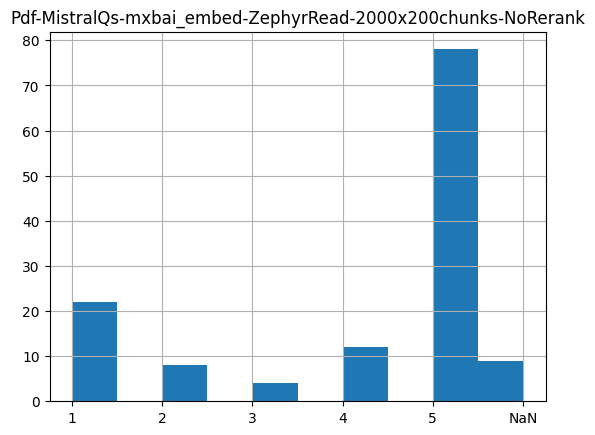

In [74]:
import matplotlib.pyplot as plt
temp.eval_score.sort_values().hist()
plt.title("Pdf-MistralQs-mxbai_embed-ZephyrRead-2000x200chunks-NoRerank");
plt.savefig('../data/pdfs_ws_mrkp_test/Pdf-MistralQs-mxbai_embed-ZephyrRead-2000x200chunks-NoRerank-Evaluated.png')

In [ ]:
if not os.path.exists("./output"):
    os.mkdir("./output")

for chunk_size in [200]:  # Add other chunk sizes (in tokens) as needed
    for embeddings in ["thenlper/gte-small"]:  # Add other embeddings as needed
        for rerank in [True, False]:
            settings_name = f"chunk:{chunk_size}_embeddings:{embeddings.replace('/', '~')}_rerank:{rerank}_reader-model:{READER_MODEL_NAME}"
            output_file_name = f"./output/rag_{settings_name}.json"

            print(f"Running evaluation for {settings_name}:")

            print("Loading knowledge base embeddings...")
            knowledge_index = load_embeddings(
                RAW_KNOWLEDGE_BASE,
                chunk_size=chunk_size,
                embedding_model_name=embeddings,
            )

            print("Running RAG...")
            reranker = (
                RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
                if rerank
                else None
            )
            run_rag_tests(
                eval_dataset=eval_dataset,
                llm=READER_LLM,
                knowledge_index=knowledge_index,
                output_file=output_file_name,
                reranker=reranker,
                verbose=False,
                test_settings=settings_name,
            )

            print("Running evaluation...")
            evaluate_answers(
                output_file_name,
                eval_chat_model,
                evaluator_name,
                evaluation_prompt_template,
            )

### Inspect results

In [ ]:
import glob

outputs = []
for file in glob.glob("./output/*.json"):
    output = pd.DataFrame(json.load(open(file, "r")))
    output["settings"] = file
    outputs.append(output)
result = pd.concat(outputs)

In [ ]:
result["eval_score_GPT4"] = result["eval_score_GPT4"].apply(
    lambda x: int(x) if isinstance(x, str) else 1
)
result["eval_score_GPT4"] = (result["eval_score_GPT4"] - 1) / 4

In [ ]:
average_scores = result.groupby("settings")["eval_score_GPT4"].mean()
average_scores.sort_values()

settings
./output/rag_chunk:200_embeddings:thenlper~gte-small_rerank:False_reader-model:zephyr-7b-beta.json       0.884328
./output/rag_chunk:200_embeddings:BAAI~bge-base-en-v1.5_rerank:False_reader-model:zephyr-7b-beta.json    0.906716
./output/rag_chunk:200_embeddings:BAAI~bge-base-en-v1.5_rerank:True_reader-model:zephyr-7b-beta.json     0.906716
./output/rag_chunk:200_embeddings:thenlper~gte-small_rerank:True_reader-model:mixtral.json               0.906716
./output/rag_chunk:200_embeddings:thenlper~gte-small_rerank:True_reader-model:zephyr-7b-beta.json        0.921642
./output/rag_chunk:200_embeddings:thenlper~gte-small_rerank:True_reader-model:mixtral0.json              0.947761
Name: eval_score_GPT4, dtype: float64

## Example results

Let us load the results that I obtained by tweaking the different options available in this notebook.
For more detail on why these options could work on not, see the notebook on [advanced_RAG](advanced_rag).

As you can see in the graph below, some tweaks do not bring any improvement, some give huge performance boosts.

➡️ ___There is no single good recipe: you should try several different directions when tuning your RAG systems.___


In [ ]:
import plotly.express as px

scores = datasets.load_dataset("m-ric/rag_scores_cookbook", split="train")
scores = pd.Series(scores["score"], index=scores["settings"])

In [ ]:
fig = px.bar(
    scores,
    color=scores,
    labels={
        "value": "Accuracy",
        "settings": "Configuration",
    },
    color_continuous_scale="bluered",
)
fig.update_layout(w
    width=1000,
    height=600,
    barmode="group",
    yaxis_range=[0, 100],
    title="<b>Accuracy of different RAG configurations</b>",
    xaxis_title="RAG settings",
    font=dict(size=15),
)
fig.layout.yaxis.ticksuffix = "%"
fig.update_coloraxes(showscale=False)
fig.update_traces(texttemplate="%{y:.1f}", textposition="outside")
fig.show()